Epoch 1/10


Validating: 100%|██████████| 79/79 [00:00<00:00, 81.09it/s]


Training Loss: 0.6730, Accuracy: 0.7919
Validation Loss: 0.2707, Accuracy: 0.9214
Epoch 2/10


Validating: 100%|██████████| 79/79 [00:00<00:00, 79.95it/s]


Training Loss: 0.2328, Accuracy: 0.9325
Validation Loss: 0.1963, Accuracy: 0.9414
Epoch 3/10


Validating: 100%|██████████| 79/79 [00:00<00:00, 94.00it/s] 


Training Loss: 0.1725, Accuracy: 0.9490
Validation Loss: 0.1500, Accuracy: 0.9536
Epoch 4/10


Validating: 100%|██████████| 79/79 [00:00<00:00, 80.66it/s]


Training Loss: 0.1392, Accuracy: 0.9589
Validation Loss: 0.1439, Accuracy: 0.9565
Epoch 5/10


Validating: 100%|██████████| 79/79 [00:00<00:00, 96.35it/s]


Training Loss: 0.1181, Accuracy: 0.9648
Validation Loss: 0.1283, Accuracy: 0.9606
Epoch 6/10


Validating: 100%|██████████| 79/79 [00:00<00:00, 83.52it/s]


Training Loss: 0.1042, Accuracy: 0.9690
Validation Loss: 0.1120, Accuracy: 0.9655
Epoch 7/10


Validating: 100%|██████████| 79/79 [00:00<00:00, 79.45it/s]


Training Loss: 0.0906, Accuracy: 0.9729
Validation Loss: 0.1122, Accuracy: 0.9646
Epoch 8/10


Validating: 100%|██████████| 79/79 [00:00<00:00, 90.38it/s]


Training Loss: 0.0812, Accuracy: 0.9754
Validation Loss: 0.1049, Accuracy: 0.9677
Epoch 9/10


Validating: 100%|██████████| 79/79 [00:00<00:00, 87.40it/s]


Training Loss: 0.0730, Accuracy: 0.9778
Validation Loss: 0.1062, Accuracy: 0.9665
Epoch 10/10


Validating: 100%|██████████| 79/79 [00:00<00:00, 84.83it/s]


Training Loss: 0.0674, Accuracy: 0.9795
Validation Loss: 0.1019, Accuracy: 0.9674


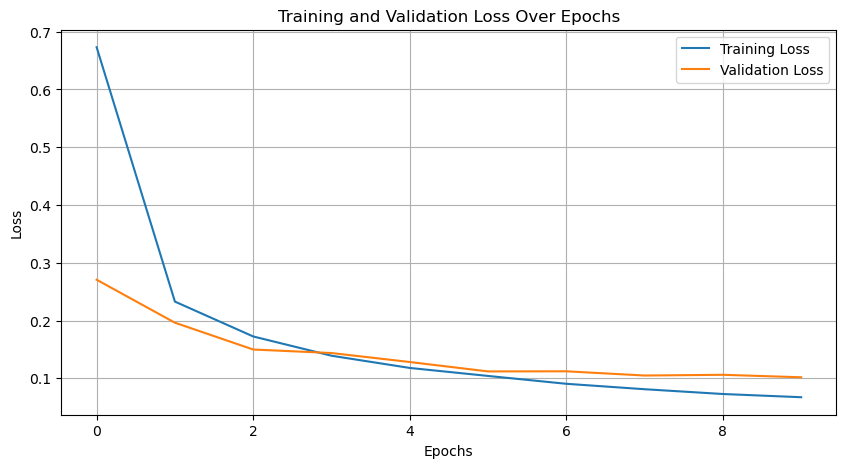

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

# Define the DNN class
class DNN(nn.Module):  # Simple deep neural network for MNIST
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

# Define the trainer class
class Trainer:
    def __init__(self, model, device, criterion, optimizer, train_loader, val_loader, epochs, path2write, collect_weights=False):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.path2write = path2write
        self.collect_weights = collect_weights

        # Initialize logging
        LOG_DIR = os.path.join(path2write, 'Log')
        os.makedirs(LOG_DIR, exist_ok=True)
        self.writer_train = SummaryWriter(os.path.join(LOG_DIR, "train"))
        self.writer_val = SummaryWriter(os.path.join(LOG_DIR, "val"))
        self.training_loss = []
        self.validation_loss = []
        self.training_accuracy = []
        self.validation_accuracy = []
        self.weight_layer_all_epoch = []
        self.weight_all_all_epoch = []
        self.weight_collection_accuracy = []

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        for inputs, targets in tqdm(self.train_loader, desc="Training"):
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            pred = outputs.argmax(dim=1)
            correct += pred.eq(targets.view_as(pred)).sum().item()

        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct / len(self.train_loader.dataset)
        self.training_loss.append(avg_loss)  # Append training loss to the list
        return avg_loss, accuracy

    def validate_one_epoch(self):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for inputs, targets in tqdm(self.val_loader, desc="Validating"):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
                pred = outputs.argmax(dim=1)
                correct += pred.eq(targets.view_as(pred)).sum().item()

        avg_loss = total_loss / len(self.val_loader)
        accuracy = correct / len(self.val_loader.dataset)
        self.validation_loss.append(avg_loss)  # Append validation loss to the list
        return avg_loss, accuracy

    def run(self):
        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}")
            train_loss, train_acc = self.train_one_epoch()
            val_loss, val_acc = self.validate_one_epoch()

            self.writer_train.add_scalar('Loss', train_loss, epoch)
            self.writer_train.add_scalar('Accuracy', train_acc, epoch)
            self.writer_val.add_scalar('Loss', val_loss, epoch)
            self.writer_val.add_scalar('Accuracy', val_acc, epoch)

            print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

            if self.collect_weights and epoch % 3 == 0:
                weights_all_epoch = []
                for name, param in self.model.named_parameters():
                    if 'weight' in name:
                        weights_all_epoch.append(param.cpu().detach().numpy().flatten())
                self.weight_all_all_epoch.append(np.concatenate(weights_all_epoch))

        if self.collect_weights:
            return self.weight_all_all_epoch, self.training_loss, self.validation_loss
        return self.training_loss, self.validation_loss  # Only return two values if collect_weights=False

# Data preparation for MNIST
def prepare_data(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    data_path = './data'  # <-- Changed path here
    train_dataset = datasets.MNIST(root=data_path, train=True, download=True, transform=transform)
    val_dataset = datasets.MNIST(root=data_path, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Initialize and run training
if __name__ == '__main__':
    # Parameters
    batch_size = 128
    epochs = 10
    lr = 0.001
    path2write = "./output"

    # Prepare data
    train_loader, val_loader = prepare_data(batch_size)

    # Model, optimizer, criterion
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Trainer instance
    trainer = Trainer(model, device, criterion, optimizer, train_loader, val_loader, epochs, path2write, collect_weights=True)

    # Run the training process
    if trainer.collect_weights:
        weights, training_loss, validation_loss = trainer.run()  # Unpack three values if weights are collected
    else:
        training_loss, validation_loss = trainer.run()  # Unpack two values if weights are not collected

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.plot(training_loss, label="Training Loss")
    plt.plot(validation_loss, label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.grid(True)
    plt.show()


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

# Trainer Class Definition
class Trainer:

    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 path2write: str = None,
                 save_best=False,
                 save_final=True,
                 save_interval=10,
                 checkpoint_start_epoch=50,
                 gradient_norm=False):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        self.path2write = path2write
        LOG_DIR = os.path.join(path2write, 'Log')
        self.writer_train = SummaryWriter(os.path.join(LOG_DIR, "train"))
        self.writer_val = SummaryWriter(os.path.join(LOG_DIR, "val"))
        self.check_point_path = os.path.join(path2write, 'check_points')
        if not os.path.exists(self.check_point_path):
            os.makedirs(self.check_point_path)
        self.save_best = save_best
        self.save_final = save_final
        self.save_interval = save_interval
        self.checkpoint_start_epoch = checkpoint_start_epoch
        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        self.gradient_norm = gradient_norm
        self.grad_list = []

    def run_trainer(self):
        self.model.to(self.device)
        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange
        progressbar = trange(self.epochs, desc='Progress', disable=False)
        loss_max = None
        for epoch in progressbar:
            print(f'Epoch - {epoch}')

            # Training Block
            train_loss = self._train()
            self.writer_train.add_scalar("Loss", train_loss, epoch)

            # Validation Block
            val_loss = self._validate()
            self.writer_val.add_scalar("Loss", val_loss, epoch)

            # Log Learning Rate
            self.writer_train.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            # Save model on the last epoch
            if self.save_final:
                if epoch == self.epochs - 1:
                    model_name = f'epoch-{epoch}-loss{val_loss:.6f}.pth'
                    torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))

            loss_max = val_loss

            if self.gradient_norm:
                grad_all = 0.0
                for p in self.model.parameters():
                    if p.grad is not None:
                        grad = (p.grad.cpu().data.numpy() ** 2).sum()
                        grad_all += grad
                self.grad_list.append(grad_all ** 0.5)

        if self.gradient_norm:
            return self.grad_list, self.training_loss
        return self.training_loss, self.validation_loss, self.model

    def _train(self):
        self.model.train()
        train_losses = []
        for x, y in tqdm(self.training_DataLoader, desc='Training', leave=False):
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            output = self.model(input)
            loss = self.criterion(output, target)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
        self.training_loss.append(np.mean(train_losses))
        return np.mean(train_losses)

    def _validate(self):
        self.model.eval()
        valid_losses = []
        for x, y in tqdm(self.validation_DataLoader, desc='Validation', leave=False):
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)  # Fix: out and target in correct order
                valid_losses.append(loss.item())
        self.validation_loss.append(np.mean(valid_losses))
        return np.mean(valid_losses)


# Define Model
class model1(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super().__init__()
        self.dense1 = nn.Linear(input_size, 10)
        self.dense2 = nn.Linear(10, 18)
        self.dense3 = nn.Linear(18, 15)
        self.dense4 = nn.Linear(15, 4)
        self.dense5 = nn.Linear(4, output_size)

    def forward(self, input_data):
        x1 = F.relu(self.dense1(input_data))
        x2 = F.relu(self.dense2(x1))
        x3 = F.relu(self.dense3(x2))
        x4 = F.relu(self.dense4(x3))
        x5 = self.dense5(x4)
        return x5


# Data preparation function
def prep_data(func, data_length=2500, train_ratio=0.7, batch_size=8, shuffle=True):
    X = np.linspace(1e-4, 1, data_length)
    y = np.array(list(map(func, X)))
    X = torch.from_numpy(X.reshape(-1, 1)).float()
    y = torch.from_numpy(y.reshape(-1, 1)).float()
    X_train, X_val = X[:int(data_length * train_ratio)], X[int(data_length * train_ratio):]
    y_train, y_val = y[:int(data_length * train_ratio)], y[int(data_length * train_ratio):]
    TrainDataLoader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=shuffle)
    ValDataLoader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=shuffle)
    return TrainDataLoader, ValDataLoader


# Hyperparameters and paths
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss()
lr = 1e-4
func1 = lambda x: (np.sin(5 * (np.pi) * x)) / (5 * np.pi * x)
epochs = 20000
path2write = "drive/MyDrive/DL_homework/HW1_1/grad_norm/"

# DataLoader preparation
training_DataLoader, validation_DataLoader = prep_data(func=func1, batch_size=4096)

# Model and Optimizer
model = model1()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Trainer initialization and run
trainer = Trainer(model=model,
                  device=device,
                  criterion=loss_fn,
                  optimizer=optimizer,
                  training_DataLoader=training_DataLoader,
                  validation_DataLoader=validation_DataLoader,
                  epochs=epochs,
                  notebook=False,
                  path2write=path2write,
                  gradient_norm=True)

grad_norm, training_loss = trainer.run_trainer()

# Plot Training Loss and Gradient Norm
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training Loss
ax1.plot(training_loss, 'r-', label='Training Loss')
ax1.legend()
ax1.set_title('Training Loss')

# Plot Gradient Norm
ax2.plot(grad_norm, 'b-', label='Gradient Norm')
ax2.legend()
ax2.set_title('Gradient Norm')

# Save the figures
plt.savefig(os.path.join(path2write, 'Training_and_Gradient_Norm.png'))

# Show the plot
plt.show()


Progress:   0%|          | 0/20000 [00:00<?, ?it/s]

Epoch - 0



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1



Training: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                                                       
Progress:   0%|          | 2/20000 [00:00<53:34,  6.22it/s]

Epoch - 2



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 5/20000 [00:00<24:49, 13.42it/s]

Epoch - 5



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 8



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 9/20000 [00:00<15:53, 20.97it/s]

Epoch - 9



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 13/20000 [00:00<13:32, 24.60it/s]

Epoch - 13



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 15



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 16



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 17/20000 [00:00<12:49, 25.95it/s]

Epoch - 17



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 20



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 21



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 22/20000 [00:00<10:36, 31.38it/s]

Epoch - 22



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 23



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 24



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 25



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 26



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 27/20000 [00:01<09:26, 35.27it/s]

Epoch - 27



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 28



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 29



Training: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 30



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 31/20000 [00:01<12:43, 26.15it/s]

Epoch - 31



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 32



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 33



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 34



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 35



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 36/20000 [00:01<10:56, 30.39it/s]

Epoch - 36



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 37



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 38



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 39



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 40



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 41/20000 [00:01<09:40, 34.38it/s]

Epoch - 41



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 42



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 43



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 44



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 45/20000 [00:01<09:28, 35.13it/s]

Epoch - 45



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 46



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 47



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 48



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 49/20000 [00:01<09:52, 33.69it/s]

Epoch - 49



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 50



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 51



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 52



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 53/20000 [00:01<09:55, 33.48it/s]

Epoch - 53



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 54



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 55



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 56



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 57/20000 [00:02<10:48, 30.75it/s]

Epoch - 57



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 58



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 59



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 60



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 61/20000 [00:02<10:08, 32.75it/s]

Epoch - 61



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 62



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 63



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]
                                                         

Epoch - 64



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 65/20000 [00:02<14:56, 22.25it/s]

Epoch - 65



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 66



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 67



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 68/20000 [00:02<14:14, 23.34it/s]

Epoch - 68



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 69



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 70



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 71



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 72/20000 [00:02<12:24, 26.75it/s]

Epoch - 72



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 73



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 74



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 75



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 76



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 77/20000 [00:02<10:43, 30.94it/s]

Epoch - 77



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 78



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 79



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 80



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 81/20000 [00:02<10:10, 32.62it/s]

Epoch - 81



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 82



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 83



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 84



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 85/20000 [00:03<10:44, 30.90it/s]

Epoch - 85



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 86



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 87



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 88



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 89/20000 [00:03<10:45, 30.85it/s]

Epoch - 89



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 90



Training: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 91



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 92



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 93/20000 [00:03<14:52, 22.30it/s]

Epoch - 93



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 94



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 95



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 96



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 97



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   0%|          | 98/20000 [00:03<12:14, 27.11it/s]

Epoch - 98



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 99



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 100



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 101



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 102/20000 [00:03<11:32, 28.74it/s]

Epoch - 102



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 103



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 104



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 105



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 106/20000 [00:03<11:45, 28.20it/s]

Epoch - 106



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 107



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 108



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 109



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 110



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 111/20000 [00:03<10:16, 32.24it/s]

Epoch - 111



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 112



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 113



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 114



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 115/20000 [00:04<09:44, 34.04it/s]

Epoch - 115



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 116



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 117



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 118



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 119



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 120/20000 [00:04<09:08, 36.21it/s]

Epoch - 120



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 121



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 122



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 123



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 124/20000 [00:04<09:30, 34.83it/s]

Epoch - 124



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]
                                                         

Epoch - 125



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 126



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 127



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 128/20000 [00:04<13:21, 24.78it/s]

Epoch - 128



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 129



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 130



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 131



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 132/20000 [00:04<12:18, 26.91it/s]

Epoch - 132



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 133



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 134



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 135



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 136/20000 [00:04<11:41, 28.31it/s]

Epoch - 136



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 137



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 138



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 139



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 140/20000 [00:04<11:15, 29.40it/s]

Epoch - 140



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 141



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 142



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 143



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 144/20000 [00:05<10:59, 30.11it/s]

Epoch - 144



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 145



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 146



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 147



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 148/20000 [00:05<10:58, 30.16it/s]

Epoch - 148



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 149



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 150



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 151



Training: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]
                                                       
Progress:   1%|          | 152/20000 [00:05<14:48, 22.34it/s]

Epoch - 152



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 153



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 154



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 155/20000 [00:05<13:56, 23.72it/s]

Epoch - 155



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 156



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 157



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 158



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 159/20000 [00:05<12:32, 26.38it/s]

Epoch - 159



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 160



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 161



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 162



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 163



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 164



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 165/20000 [00:05<10:05, 32.76it/s]

Epoch - 165



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 166



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 167



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 168



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 169



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 170/20000 [00:05<09:23, 35.21it/s]

Epoch - 170



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 171



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 172



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 173



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 174/20000 [00:06<09:56, 33.24it/s]

Epoch - 174



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 175



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 176



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 177



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 178/20000 [00:06<09:40, 34.12it/s]

Epoch - 178



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 179



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 180



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 181



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 182/20000 [00:06<10:06, 32.70it/s]

Epoch - 182



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 183



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 184



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 185



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 186/20000 [00:06<14:50, 22.24it/s]

Epoch - 186



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 187



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 188



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 189



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 190



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 191/20000 [00:06<12:13, 27.00it/s]

Epoch - 191



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 192



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 193



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 194



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 195



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 196/20000 [00:06<10:33, 31.27it/s]

Epoch - 196



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 197



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 198



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 199



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 200



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 201/20000 [00:06<09:29, 34.78it/s]

Epoch - 201



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 202



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 203



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 204



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 205



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 206/20000 [00:07<08:47, 37.52it/s]

Epoch - 206



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 207



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 208



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 209



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 210



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 211/20000 [00:07<08:33, 38.52it/s]

Epoch - 211



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 212



Training: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 213



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 214



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 215



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 216/20000 [00:07<12:17, 26.82it/s]

Epoch - 216



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 217



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 218



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 219



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 220/20000 [00:07<11:19, 29.11it/s]

Epoch - 220



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 221



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 222



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 223



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 224/20000 [00:07<11:32, 28.56it/s]

Epoch - 224



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 225



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 226



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 227



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 228/20000 [00:07<11:15, 29.28it/s]

Epoch - 228



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 229



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 230



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 231



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 232/20000 [00:07<10:44, 30.67it/s]

Epoch - 232



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 233



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 234



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 235



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 236



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 237/20000 [00:08<09:41, 33.98it/s]

Epoch - 237



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 238



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 239



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 240



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 241/20000 [00:08<09:32, 34.53it/s]

Epoch - 241



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 242



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 243



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 244



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 245/20000 [00:08<09:52, 33.37it/s]

Epoch - 245



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 246



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]
                                                         

Epoch - 247



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 248



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|          | 249/20000 [00:08<14:22, 22.89it/s]

Epoch - 249



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 250



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 251



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 252



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 253



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 254/20000 [00:08<11:56, 27.58it/s]

Epoch - 254



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 255



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 256



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 257



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 258



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 259/20000 [00:08<10:18, 31.94it/s]

Epoch - 259



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 260



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 261



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 262



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 263



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 264/20000 [00:08<09:19, 35.27it/s]

Epoch - 264



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 265



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 266



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 267



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 268/20000 [00:09<09:49, 33.45it/s]

Epoch - 268



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 269



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 270



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 271



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 272/20000 [00:09<09:47, 33.61it/s]

Epoch - 272



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 273



Training: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 274



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 275



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 276/20000 [00:09<13:38, 24.10it/s]

Epoch - 276



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 277



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 278



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 279/20000 [00:09<13:26, 24.44it/s]

Epoch - 279



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 280



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 281



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 282



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 283/20000 [00:09<12:30, 26.26it/s]

Epoch - 283



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 284



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 285



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 286/20000 [00:09<12:33, 26.15it/s]

Epoch - 286



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 287



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 288



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 289/20000 [00:09<12:40, 25.93it/s]

Epoch - 289



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 290



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 291



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 292



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 293



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 294/20000 [00:10<10:33, 31.12it/s]

Epoch - 294



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 295



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 296



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 297



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   1%|▏         | 298/20000 [00:10<10:58, 29.92it/s]

Epoch - 298



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 299



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 300



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 301



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 302/20000 [00:10<11:00, 29.81it/s]

Epoch - 302



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 303



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 304



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 305



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 306/20000 [00:10<11:15, 29.15it/s]

Epoch - 306



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 307



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]
                                                         

Epoch - 308



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 309/20000 [00:10<14:59, 21.88it/s]

Epoch - 309



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 310



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 311



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 312



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 313



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 314/20000 [00:10<12:16, 26.73it/s]

Epoch - 314



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 315



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 316



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 317



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 318



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 319/20000 [00:10<10:32, 31.10it/s]

Epoch - 319



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 320



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 321



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 322



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 323



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 324/20000 [00:11<09:28, 34.63it/s]

Epoch - 324



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 325



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 326



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 327



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 328



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 329/20000 [00:11<08:44, 37.54it/s]

Epoch - 329



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 330



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 331



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 332



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 333



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 334/20000 [00:11<09:27, 34.68it/s]

Epoch - 334



Training: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 335



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 336



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 337



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 338/20000 [00:11<13:43, 23.87it/s]

Epoch - 338



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 339



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 340



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 341/20000 [00:11<13:15, 24.73it/s]

Epoch - 341



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 342



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 343



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 344



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 345/20000 [00:11<12:12, 26.82it/s]

Epoch - 345



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 346



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 347



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 348



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 349/20000 [00:12<11:23, 28.74it/s]

Epoch - 349



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 350



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 351



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 352



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 353/20000 [00:12<10:42, 30.56it/s]

Epoch - 353



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 354



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 355



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 356



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 357



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 358/20000 [00:12<09:18, 35.18it/s]

Epoch - 358



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 359



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 360



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 361



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 362/20000 [00:12<09:44, 33.59it/s]

Epoch - 362



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 363



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 364



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 365



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 366/20000 [00:12<10:00, 32.69it/s]

Epoch - 366



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 367



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 368



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]
                                                         

Epoch - 369



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 370/20000 [00:12<13:12, 24.77it/s]

Epoch - 370



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 371



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 372



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 373/20000 [00:12<12:59, 25.18it/s]

Epoch - 373



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 374



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 375



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 376/20000 [00:12<12:42, 25.73it/s]

Epoch - 376



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 377



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 378



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 379



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 380



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 381/20000 [00:13<10:50, 30.14it/s]

Epoch - 381



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 382



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 383



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 384



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 385



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 386/20000 [00:13<09:32, 34.29it/s]

Epoch - 386



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 387



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 388



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 389



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 390/20000 [00:13<10:18, 31.73it/s]

Epoch - 390



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 391



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 392



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 393



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 394/20000 [00:13<10:02, 32.52it/s]

Epoch - 394



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 395



Training: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 396



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 397



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 398/20000 [00:13<14:20, 22.78it/s]

Epoch - 398



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 399



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 400



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 401



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 402/20000 [00:13<13:02, 25.04it/s]

Epoch - 402



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 403



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 404



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 405



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 406/20000 [00:14<11:35, 28.15it/s]

Epoch - 406



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 407



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 408



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 409



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 410



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 411/20000 [00:14<10:19, 31.62it/s]

Epoch - 411



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 412



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 413



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 414



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 415/20000 [00:14<09:52, 33.08it/s]

Epoch - 415



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 416



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 417



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 418



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 419



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 420/20000 [00:14<08:53, 36.70it/s]

Epoch - 420



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 421



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 422



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 423



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 424



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 425/20000 [00:14<08:40, 37.62it/s]

Epoch - 425



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 426



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 427



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 428



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 429/20000 [00:14<08:44, 37.33it/s]

Epoch - 429



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
                                                         

Epoch - 430



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 431



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 432



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 433/20000 [00:14<13:54, 23.46it/s]

Epoch - 433



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 434



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 435



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 436



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 437/20000 [00:15<13:22, 24.38it/s]

Epoch - 437



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 438



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 439



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 440



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 441/20000 [00:15<12:26, 26.20it/s]

Epoch - 441



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 442



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 443



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 444



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 445/20000 [00:15<11:55, 27.32it/s]

Epoch - 445



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 446



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 447



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 448



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 449/20000 [00:15<11:49, 27.54it/s]

Epoch - 449



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 450



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 451



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 452/20000 [00:15<11:47, 27.62it/s]

Epoch - 452



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 453



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 454



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 455/20000 [00:15<11:55, 27.31it/s]

Epoch - 455



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 456



Training: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 457



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 458/20000 [00:15<17:08, 19.01it/s]

Epoch - 458



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 459



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 460



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 461



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 462/20000 [00:16<14:33, 22.36it/s]

Epoch - 462



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 463



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 464



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 465



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 466/20000 [00:16<13:07, 24.79it/s]

Epoch - 466



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 467



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 468



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 469



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 470



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 471/20000 [00:16<11:11, 29.09it/s]

Epoch - 471



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 472



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 473



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 474



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 475



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 476/20000 [00:16<09:52, 32.94it/s]

Epoch - 476



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 477



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 478



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 479



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 480/20000 [00:16<10:28, 31.06it/s]

Epoch - 480



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 481



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 482



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 483



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 484/20000 [00:16<10:29, 30.99it/s]

Epoch - 484



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 485



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 486



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 487



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 488/20000 [00:16<10:26, 31.12it/s]

Epoch - 488



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 489



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 490



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]
                                                         

Epoch - 491



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 492/20000 [00:17<13:45, 23.65it/s]

Epoch - 492



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 493



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 494



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 495



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▏         | 496/20000 [00:17<12:51, 25.29it/s]

Epoch - 496



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 497



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 498



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 499



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   2%|▎         | 500/20000 [00:17<12:04, 26.91it/s]

Epoch - 500



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 501



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 502



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 503/20000 [00:17<12:24, 26.20it/s]

Epoch - 503



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 504



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 505



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 506/20000 [00:17<12:50, 25.29it/s]

Epoch - 506



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 507



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 508



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 509/20000 [00:17<12:24, 26.19it/s]

Epoch - 509



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 510



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 511



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 512



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 513/20000 [00:17<11:39, 27.88it/s]

Epoch - 513



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 514



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 515



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 516/20000 [00:18<12:34, 25.82it/s]

Epoch - 516



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 517



Training: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 518



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 519/20000 [00:18<17:23, 18.67it/s]

Epoch - 519



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 520



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 521



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 522



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 523/20000 [00:18<14:50, 21.87it/s]

Epoch - 523



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 524



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 525



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 526



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 527/20000 [00:18<13:20, 24.33it/s]

Epoch - 527



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 528



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 529



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 530



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 531/20000 [00:18<11:52, 27.32it/s]

Epoch - 531



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 532



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 533



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 534/20000 [00:18<11:54, 27.26it/s]

Epoch - 534



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 535



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 536



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 537/20000 [00:18<12:09, 26.70it/s]

Epoch - 537



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 538



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 539



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 540



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 541



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 542/20000 [00:18<10:09, 31.91it/s]

Epoch - 542



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 543



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 544



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 545



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 546/20000 [00:19<10:19, 31.43it/s]

Epoch - 546



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 547



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 548



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 549



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 550/20000 [00:19<09:53, 32.79it/s]

Epoch - 550



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 551



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
                                                         

Epoch - 552



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 553



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 554/20000 [00:19<14:40, 22.09it/s]

Epoch - 554



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 555



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 556



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 557



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 558



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 559/20000 [00:19<12:27, 26.01it/s]

Epoch - 559



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 560



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 561



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 562



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 563/20000 [00:19<11:23, 28.44it/s]

Epoch - 563



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 564



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 565



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 566



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 567/20000 [00:19<11:05, 29.18it/s]

Epoch - 567



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 568



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 569



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 570



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 571/20000 [00:20<11:08, 29.08it/s]

Epoch - 571



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 572



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 573



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 574



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 575/20000 [00:20<10:57, 29.56it/s]

Epoch - 575



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 576



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 577



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 578



Training: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
                                                       
Progress:   3%|▎         | 579/20000 [00:20<13:55, 23.24it/s]

Epoch - 579



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 580



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 581



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 582



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 583/20000 [00:20<12:48, 25.27it/s]

Epoch - 583



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 584



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 585



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 586



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 587/20000 [00:20<11:28, 28.21it/s]

Epoch - 587



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 588



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 589



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 590



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 591/20000 [00:20<11:25, 28.33it/s]

Epoch - 591



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 592



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 593



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 594



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 595



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 596/20000 [00:20<09:53, 32.69it/s]

Epoch - 596



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 597



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 598



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 599



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 600



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 601/20000 [00:21<08:56, 36.15it/s]

Epoch - 601



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 602



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 603



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 604



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 605/20000 [00:21<09:52, 32.73it/s]

Epoch - 605



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 606



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 607



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 608



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 609/20000 [00:21<09:47, 33.02it/s]

Epoch - 609



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 610



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 611



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 612



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 613/20000 [00:21<13:13, 24.43it/s]

Epoch - 613



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 614



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 615



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 616



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 617



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 618/20000 [00:21<11:23, 28.34it/s]

Epoch - 618



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 619



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 620



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 621



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 622/20000 [00:21<10:48, 29.90it/s]

Epoch - 622



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 623



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 624



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 625



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 626/20000 [00:21<11:04, 29.15it/s]

Epoch - 626



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 627



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 628



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 629



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 630/20000 [00:22<10:57, 29.45it/s]

Epoch - 630



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 631



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 632



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 633



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 634/20000 [00:22<10:29, 30.75it/s]

Epoch - 634



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 635



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 636



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 637



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 638/20000 [00:22<10:11, 31.64it/s]

Epoch - 638



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 639



Training: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 640



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 641



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 642/20000 [00:22<13:39, 23.62it/s]

Epoch - 642



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 643



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 644



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 645



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 646



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 647/20000 [00:22<11:24, 28.26it/s]

Epoch - 647



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 648



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 649



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 650



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 651



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 652/20000 [00:22<09:52, 32.64it/s]

Epoch - 652



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 653



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 654



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 655



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 656/20000 [00:22<09:42, 33.20it/s]

Epoch - 656



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 657



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 658



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 659



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 660/20000 [00:23<09:53, 32.60it/s]

Epoch - 660



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 661



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 662



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 663



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 664/20000 [00:23<10:11, 31.60it/s]

Epoch - 664



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 665



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 666



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 667



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 668



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 669/20000 [00:23<09:13, 34.92it/s]

Epoch - 669



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 670



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 671



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 672



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 673



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 674/20000 [00:23<12:31, 25.73it/s]

Epoch - 674



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 675



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 676



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 677



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 678/20000 [00:23<12:02, 26.73it/s]

Epoch - 678



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 679



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 680



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 681



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 682



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 683/20000 [00:23<11:02, 29.16it/s]

Epoch - 683



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 684



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 685



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 686



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 687/20000 [00:24<12:29, 25.76it/s]

Epoch - 687



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 688



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 689



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 690/20000 [00:24<13:11, 24.38it/s]

Epoch - 690



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 691



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 692



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 693



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 694/20000 [00:24<11:47, 27.28it/s]

Epoch - 694



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 695



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 696



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 697



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   3%|▎         | 698/20000 [00:24<10:44, 29.96it/s]

Epoch - 698



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 699



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 700



Training: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 701



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 702/20000 [00:24<14:54, 21.57it/s]

Epoch - 702



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 703



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 704



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 705/20000 [00:24<14:11, 22.66it/s]

Epoch - 705



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 706



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 707



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 708



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 709/20000 [00:24<12:31, 25.68it/s]

Epoch - 709



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 710



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 711



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 712/20000 [00:25<12:09, 26.45it/s]

Epoch - 712



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 713



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 714



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 715



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 716/20000 [00:25<10:53, 29.50it/s]

Epoch - 716



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 717



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 718



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 719



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 720



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 721/20000 [00:25<09:19, 34.47it/s]

Epoch - 721



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 722



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 723



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 724



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 725



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 726/20000 [00:25<08:42, 36.90it/s]

Epoch - 726



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 727



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 728



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 729



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 730



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 731/20000 [00:25<08:34, 37.48it/s]

Epoch - 731



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 732



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 733



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 734



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 735/20000 [00:25<13:05, 24.53it/s]

Epoch - 735



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 736



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 737



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 738



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 739/20000 [00:25<11:56, 26.89it/s]

Epoch - 739



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 740



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 741



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 742



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 743



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 744/20000 [00:26<10:30, 30.54it/s]

Epoch - 744



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 745



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 746



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 747



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 748



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▎         | 749/20000 [00:26<09:44, 32.95it/s]

Epoch - 749



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 750



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 751



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 752



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 753/20000 [00:26<09:20, 34.36it/s]

Epoch - 753



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 754



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 755



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 756



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 757



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 758/20000 [00:26<08:35, 37.32it/s]

Epoch - 758



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 759



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 760



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 761



Training: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
                                                       
Progress:   4%|▍         | 762/20000 [00:26<12:28, 25.70it/s]

Epoch - 762



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 763



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 764



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 765



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 766/20000 [00:26<12:03, 26.57it/s]

Epoch - 766



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 767



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 768



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 769



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 770/20000 [00:26<11:42, 27.36it/s]

Epoch - 770



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 771



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 772



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 773



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 774/20000 [00:27<10:45, 29.77it/s]

Epoch - 774



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 775



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 776



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 777



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 778/20000 [00:27<10:53, 29.42it/s]

Epoch - 778



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 779



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 780



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 781



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 782



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 783/20000 [00:27<09:45, 32.85it/s]

Epoch - 783



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 784



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 785



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 786



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 787



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 788/20000 [00:27<08:50, 36.24it/s]

Epoch - 788



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 789



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 790



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 791



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 792



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 793/20000 [00:27<08:12, 38.97it/s]

Epoch - 793



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 794



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 795



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
                                                         

Epoch - 796



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 797



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 798/20000 [00:27<11:28, 27.89it/s]

Epoch - 798



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 799



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 800



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 801



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 802/20000 [00:27<10:59, 29.11it/s]

Epoch - 802



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 803



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 804



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 805



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 806



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 807/20000 [00:28<09:43, 32.89it/s]

Epoch - 807



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 808



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 809



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 810



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 811



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 812/20000 [00:28<08:59, 35.56it/s]

Epoch - 812



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 813



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 814



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 815



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 816/20000 [00:28<09:44, 32.83it/s]

Epoch - 816



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 817



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 818



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 819



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 820/20000 [00:28<09:41, 32.96it/s]

Epoch - 820



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 821



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 822



Training: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 823



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 824/20000 [00:28<14:13, 22.46it/s]

Epoch - 824



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 825



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 826



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 827/20000 [00:28<13:44, 23.25it/s]

Epoch - 827



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 828



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 829



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 830/20000 [00:28<13:11, 24.23it/s]

Epoch - 830



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 831



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 832



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 833



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 834/20000 [00:29<11:43, 27.25it/s]

Epoch - 834



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 835



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 836



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 837



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 838



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 839/20000 [00:29<10:14, 31.19it/s]

Epoch - 839



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 840



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 841



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 842



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 843



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 844/20000 [00:29<09:05, 35.12it/s]

Epoch - 844



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 845



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 846



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 847



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 848



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 849/20000 [00:29<08:24, 37.96it/s]

Epoch - 849



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 850



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 851



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 852



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 853



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 854/20000 [00:29<08:11, 38.95it/s]

Epoch - 854



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 855



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 856



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]
                                                         

Epoch - 857



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 858



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 859/20000 [00:29<12:33, 25.39it/s]

Epoch - 859



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 860



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 861



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 862



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 863



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 864/20000 [00:29<10:52, 29.31it/s]

Epoch - 864



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 865



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 866



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 867



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 868/20000 [00:30<10:23, 30.69it/s]

Epoch - 868



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 869



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 870



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 871



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 872/20000 [00:30<10:35, 30.08it/s]

Epoch - 872



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 873



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 874



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 875



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 876



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 877/20000 [00:30<09:30, 33.51it/s]

Epoch - 877



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 878



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 879



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 880



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 881



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 882/20000 [00:30<08:36, 37.01it/s]

Epoch - 882



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 883



Training: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 884



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 885



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 886



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 887/20000 [00:30<12:17, 25.93it/s]

Epoch - 887



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 888



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 889



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 890



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 891/20000 [00:30<11:22, 27.99it/s]

Epoch - 891



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 892



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 893



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 894



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 895/20000 [00:31<10:34, 30.12it/s]

Epoch - 895



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 896



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 897



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 898



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 899



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   4%|▍         | 900/20000 [00:31<09:47, 32.51it/s]

Epoch - 900



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 901



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 902



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 903



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 904/20000 [00:31<09:43, 32.75it/s]

Epoch - 904



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 905



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 906



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 907



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 908/20000 [00:31<09:37, 33.06it/s]

Epoch - 908



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 909



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 910



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 911



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 912/20000 [00:31<09:17, 34.24it/s]

Epoch - 912



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 913



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 914



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 915



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 916/20000 [00:31<09:27, 33.63it/s]

Epoch - 916



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 917



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]
                                                         

Epoch - 918



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 919



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 920/20000 [00:31<12:59, 24.48it/s]

Epoch - 920



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 921



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 922



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 923



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 924/20000 [00:32<12:30, 25.41it/s]

Epoch - 924



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 925



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 926



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 927/20000 [00:32<12:04, 26.33it/s]

Epoch - 927



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 928



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 929



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 930



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 931/20000 [00:32<11:15, 28.25it/s]

Epoch - 931



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 932



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 933



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 934



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 935/20000 [00:32<10:57, 28.99it/s]

Epoch - 935



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 936



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 937



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 938



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 939/20000 [00:32<10:35, 30.02it/s]

Epoch - 939



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 940



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 941



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 942



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 943/20000 [00:32<09:56, 31.96it/s]

Epoch - 943



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 944



Training: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 945



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 946



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 947/20000 [00:32<13:44, 23.12it/s]

Epoch - 947



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 948



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 949



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 950



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 951/20000 [00:32<11:59, 26.46it/s]

Epoch - 951



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 952



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 953



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 954



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 955/20000 [00:33<11:15, 28.20it/s]

Epoch - 955



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 956



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 957



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 958



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 959



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 960/20000 [00:33<09:47, 32.40it/s]

Epoch - 960



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 961



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 962



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 963



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 964/20000 [00:33<09:30, 33.37it/s]

Epoch - 964



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 965



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 966



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 967



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 968/20000 [00:33<09:05, 34.92it/s]

Epoch - 968



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 969



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 970



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 971



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 972/20000 [00:33<08:54, 35.61it/s]

Epoch - 972



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 973



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 974



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 975



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 976/20000 [00:33<09:06, 34.78it/s]

Epoch - 976



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 977



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 978



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]
                                                         

Epoch - 979



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 980/20000 [00:33<13:00, 24.38it/s]

Epoch - 980



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 981



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 982



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 983/20000 [00:34<12:44, 24.87it/s]

Epoch - 983



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 984



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 985



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 986



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 987/20000 [00:34<11:31, 27.48it/s]

Epoch - 987



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 988



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 989



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 990



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 991



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 992/20000 [00:34<10:04, 31.42it/s]

Epoch - 992



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 993



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 994



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 995



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▍         | 996/20000 [00:34<09:36, 32.95it/s]

Epoch - 996



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 997



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 998



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 999



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1000/20000 [00:34<09:49, 32.22it/s]

Epoch - 1000



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1001



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1002



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1003



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1004/20000 [00:34<10:16, 30.80it/s]

Epoch - 1004



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1005



Training: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1006



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1007



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1008/20000 [00:34<14:30, 21.81it/s]

Epoch - 1008



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1009



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1010



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1011



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1012/20000 [00:35<12:35, 25.12it/s]

Epoch - 1012



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1013



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1014



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1015



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1016



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1017/20000 [00:35<10:34, 29.90it/s]

Epoch - 1017



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1018



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1019



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1020



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1021/20000 [00:35<10:38, 29.75it/s]

Epoch - 1021



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1022



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1023



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1024



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1025



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1026/20000 [00:35<09:36, 32.92it/s]

Epoch - 1026



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1027



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1028



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1029



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1030/20000 [00:35<09:34, 33.01it/s]

Epoch - 1030



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1031



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1032



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1033



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1034/20000 [00:35<09:34, 32.99it/s]

Epoch - 1034



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1035



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1036



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1037



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1038/20000 [00:35<10:00, 31.56it/s]

Epoch - 1038



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1039



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]
                                                         

Epoch - 1040



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1041



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1042/20000 [00:36<13:25, 23.53it/s]

Epoch - 1042



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1043



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1044



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1045



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1046/20000 [00:36<12:09, 25.98it/s]

Epoch - 1046



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1047



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1048



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1049/20000 [00:36<12:07, 26.06it/s]

Epoch - 1049



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1050



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1051



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1052/20000 [00:36<12:03, 26.19it/s]

Epoch - 1052



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1053



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1054



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1055



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1056/20000 [00:36<11:17, 27.94it/s]

Epoch - 1056



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1057



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1058



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1059



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1060/20000 [00:36<10:42, 29.47it/s]

Epoch - 1060



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1061



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1062



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1063



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1064/20000 [00:36<10:48, 29.18it/s]

Epoch - 1064



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1065



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1066



Training: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]
                                                       
Progress:   5%|▌         | 1067/20000 [00:37<14:33, 21.67it/s]

Epoch - 1067



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1068



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1069



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1070



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1071



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1072/20000 [00:37<11:40, 27.01it/s]

Epoch - 1072



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1073



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1074



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1075



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1076



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1077/20000 [00:37<10:07, 31.14it/s]

Epoch - 1077



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1078



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1079



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1080



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1081/20000 [00:37<09:50, 32.02it/s]

Epoch - 1081



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1082



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1083



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1084



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1085/20000 [00:37<09:51, 31.98it/s]

Epoch - 1085



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1086



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1087



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1088



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1089/20000 [00:37<09:33, 32.96it/s]

Epoch - 1089



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1090



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1091



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1092



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1093/20000 [00:37<09:47, 32.18it/s]

Epoch - 1093



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1094



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1095



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1096



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   5%|▌         | 1097/20000 [00:37<10:12, 30.85it/s]

Epoch - 1097



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1098



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1099



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1100



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1101/20000 [00:38<13:10, 23.90it/s]

Epoch - 1101



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1102



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1103



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1104



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1105/20000 [00:38<11:44, 26.83it/s]

Epoch - 1105



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1106



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1107



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1108



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1109



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1110/20000 [00:38<10:02, 31.37it/s]

Epoch - 1110



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1111



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1112



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1113



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1114



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1115/20000 [00:38<08:55, 35.29it/s]

Epoch - 1115



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1116



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1117



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1118



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1119/20000 [00:38<09:03, 34.71it/s]

Epoch - 1119



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1120



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1121



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1122



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1123/20000 [00:38<08:52, 35.42it/s]

Epoch - 1123



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1124



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1125



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1126



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1127



Training: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
                                                       
Progress:   6%|▌         | 1128/20000 [00:38<11:44, 26.78it/s]

Epoch - 1128



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1129



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1130



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1131



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1132



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1133/20000 [00:39<10:54, 28.84it/s]

Epoch - 1133



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1134



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1135



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1136



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1137/20000 [00:39<10:50, 29.01it/s]

Epoch - 1137



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1138



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1139



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1140



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1141/20000 [00:39<10:32, 29.79it/s]

Epoch - 1141



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1142



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1143



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1144



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1145



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1146/20000 [00:39<09:20, 33.62it/s]

Epoch - 1146



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1147



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1148



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1149



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1150



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1151/20000 [00:39<08:31, 36.84it/s]

Epoch - 1151



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1152



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1153



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1154



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1155



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1156/20000 [00:39<08:20, 37.68it/s]

Epoch - 1156



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1157



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1158



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1159



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1160/20000 [00:39<08:17, 37.88it/s]

Epoch - 1160



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1161



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]
                                                         

Epoch - 1162



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1163



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1164/20000 [00:40<11:52, 26.44it/s]

Epoch - 1164



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1165



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1166



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1167



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1168/20000 [00:40<11:14, 27.91it/s]

Epoch - 1168



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1169



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1170



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1171



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1172



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1173/20000 [00:40<09:49, 31.93it/s]

Epoch - 1173



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1174



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1175



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1176



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1177/20000 [00:40<09:23, 33.41it/s]

Epoch - 1177



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1178



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1179



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1180



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1181/20000 [00:40<09:16, 33.79it/s]

Epoch - 1181



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1182



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1183



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1184



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1185/20000 [00:40<09:00, 34.84it/s]

Epoch - 1185



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1186



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1187



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1188



Training: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]
                                                       
Progress:   6%|▌         | 1189/20000 [00:40<12:53, 24.33it/s]

Epoch - 1189



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1190



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1191



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1192/20000 [00:41<12:18, 25.46it/s]

Epoch - 1192



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1193



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1194



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1195



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1196/20000 [00:41<11:07, 28.17it/s]

Epoch - 1196



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1197



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1198



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1199



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1200



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1201/20000 [00:41<09:43, 32.20it/s]

Epoch - 1201



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1202



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1203



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1204



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1205/20000 [00:41<09:57, 31.48it/s]

Epoch - 1205



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1206



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1207



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1208



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1209/20000 [00:41<10:07, 30.95it/s]

Epoch - 1209



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1210



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1211



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1212



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1213/20000 [00:41<09:43, 32.19it/s]

Epoch - 1213



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1214



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1215



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1216



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1217



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1218/20000 [00:41<08:50, 35.41it/s]

Epoch - 1218



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1219



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1220



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1221



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1222/20000 [00:41<08:41, 36.02it/s]

Epoch - 1222



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
                                                         

Epoch - 1223



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1224



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1225



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1226/20000 [00:42<12:59, 24.09it/s]

Epoch - 1226



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1227



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1228



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1229



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1230/20000 [00:42<12:12, 25.64it/s]

Epoch - 1230



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1231



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1232



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1233/20000 [00:42<12:01, 26.03it/s]

Epoch - 1233



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1234



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1235



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1236



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1237/20000 [00:42<11:20, 27.57it/s]

Epoch - 1237



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1238



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1239



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1240



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1241



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1242/20000 [00:42<09:56, 31.44it/s]

Epoch - 1242



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1243



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1244



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1245



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1246



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▌         | 1247/20000 [00:42<08:51, 35.27it/s]

Epoch - 1247



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1248



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1249



Training: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1250



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1251/20000 [00:43<12:17, 25.41it/s]

Epoch - 1251



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1252



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1253



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1254



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1255



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1256/20000 [00:43<10:28, 29.83it/s]

Epoch - 1256



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1257



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1258



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1259



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1260



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1261/20000 [00:43<09:18, 33.53it/s]

Epoch - 1261



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1262



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1263



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1264



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1265



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1266/20000 [00:43<08:27, 36.94it/s]

Epoch - 1266



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1267



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1268



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1269



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1270



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1271/20000 [00:43<07:52, 39.63it/s]

Epoch - 1271



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1272



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1273



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1274



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1275



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1276/20000 [00:43<08:12, 38.00it/s]

Epoch - 1276



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1277



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1278



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1279



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1280



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1281/20000 [00:43<07:52, 39.61it/s]

Epoch - 1281



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1282



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1283



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
                                                         

Epoch - 1284



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1285



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1286/20000 [00:44<11:12, 27.81it/s]

Epoch - 1286



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1287



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1288



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1289



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1290/20000 [00:44<11:19, 27.52it/s]

Epoch - 1290



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1291



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1292



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1293



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1294/20000 [00:44<10:57, 28.47it/s]

Epoch - 1294



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1295



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1296



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1297



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   6%|▋         | 1298/20000 [00:44<10:55, 28.54it/s]

Epoch - 1298



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1299



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1300



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1301



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1302/20000 [00:44<11:01, 28.28it/s]

Epoch - 1302



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1303



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1304



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1305/20000 [00:44<10:53, 28.60it/s]

Epoch - 1305



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1306



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1307



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1308



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1309/20000 [00:44<10:18, 30.22it/s]

Epoch - 1309



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1310



Training: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1311



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1312



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1313/20000 [00:45<13:00, 23.95it/s]

Epoch - 1313



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1314



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1315



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1316



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1317



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1318/20000 [00:45<10:47, 28.83it/s]

Epoch - 1318



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1319



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1320



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1321



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1322



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1323/20000 [00:45<09:28, 32.83it/s]

Epoch - 1323



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1324



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1325



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1326



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1327/20000 [00:45<09:03, 34.33it/s]

Epoch - 1327



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1328



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1329



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1330



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1331



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1332/20000 [00:45<08:12, 37.93it/s]

Epoch - 1332



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1333



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1334



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1335



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1336



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1337/20000 [00:45<10:00, 31.09it/s]

Epoch - 1337



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1338



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1339



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1340



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1341/20000 [00:45<10:44, 28.94it/s]

Epoch - 1341



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1342



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1343



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1344



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1345/20000 [00:46<15:04, 20.62it/s]

Epoch - 1345



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1346



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1347



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1348



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1349



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1350/20000 [00:46<12:27, 24.94it/s]

Epoch - 1350



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1351



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1352



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1353



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1354/20000 [00:46<11:29, 27.04it/s]

Epoch - 1354



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1355



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1356



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1357



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1358/20000 [00:46<10:42, 29.02it/s]

Epoch - 1358



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1359



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1360



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1361



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1362/20000 [00:46<10:22, 29.95it/s]

Epoch - 1362



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1363



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1364



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1365



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1366



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1367/20000 [00:46<09:05, 34.17it/s]

Epoch - 1367



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1368



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1369



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1370



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1371



Training: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]
                                                       
Progress:   7%|▋         | 1372/20000 [00:47<11:52, 26.16it/s]

Epoch - 1372



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1373



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1374



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1375



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1376/20000 [00:47<11:11, 27.73it/s]

Epoch - 1376



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1377



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1378



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1379



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1380/20000 [00:47<10:30, 29.53it/s]

Epoch - 1380



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1381



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1382



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1383



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1384



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1385/20000 [00:47<09:16, 33.46it/s]

Epoch - 1385



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1386



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1387



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1388



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1389



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1390/20000 [00:47<08:33, 36.25it/s]

Epoch - 1390



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1391



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1392



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1393



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1394/20000 [00:47<09:20, 33.18it/s]

Epoch - 1394



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1395



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1396



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1397



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1398/20000 [00:47<08:54, 34.80it/s]

Epoch - 1398



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1399



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1400



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1401



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1402



Training: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]
                                                       
Progress:   7%|▋         | 1403/20000 [00:48<11:46, 26.32it/s]

Epoch - 1403



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1404



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1405



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1406



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1407/20000 [00:48<11:30, 26.93it/s]

Epoch - 1407



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1408



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1409



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1410



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1411/20000 [00:48<10:47, 28.72it/s]

Epoch - 1411



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1412



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1413



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1414



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1415



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1416/20000 [00:48<09:26, 32.83it/s]

Epoch - 1416



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1417



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1418



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1419



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1420



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1421/20000 [00:48<08:32, 36.24it/s]

Epoch - 1421



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1422



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1423



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1424



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1425/20000 [00:48<08:29, 36.42it/s]

Epoch - 1425



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1426



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1427



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1428



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1429/20000 [00:48<09:16, 33.37it/s]

Epoch - 1429



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1430



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1431



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1432



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1433/20000 [00:48<09:26, 32.75it/s]

Epoch - 1433



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1434



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1435



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1436



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1437/20000 [00:49<13:05, 23.65it/s]

Epoch - 1437



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1438



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1439



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1440/20000 [00:49<12:52, 24.02it/s]

Epoch - 1440



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1441



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1442



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1443



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1444/20000 [00:49<11:36, 26.65it/s]

Epoch - 1444



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1445



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1446



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1447/20000 [00:49<11:42, 26.42it/s]

Epoch - 1447



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1448



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1449



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1450



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1451/20000 [00:49<10:53, 28.37it/s]

Epoch - 1451



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1452



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1453



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1454



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1455/20000 [00:49<10:34, 29.21it/s]

Epoch - 1455



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1456



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1457



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1458



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1459



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1460/20000 [00:49<09:20, 33.05it/s]

Epoch - 1460



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1461



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1462



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1463



Training: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]
                                                       
Progress:   7%|▋         | 1464/20000 [00:50<12:29, 24.72it/s]

Epoch - 1464



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1465



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1466



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1467/20000 [00:50<12:18, 25.11it/s]

Epoch - 1467



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1468



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1469



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1470/20000 [00:50<12:00, 25.73it/s]

Epoch - 1470



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1471



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1472



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1473/20000 [00:50<12:06, 25.50it/s]

Epoch - 1473



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1474



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1475



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1476/20000 [00:50<11:42, 26.38it/s]

Epoch - 1476



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1477



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1478



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1479



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1480/20000 [00:50<11:11, 27.58it/s]

Epoch - 1480



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1481



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1482



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1483/20000 [00:50<11:11, 27.57it/s]

Epoch - 1483



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1484



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1485



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1486



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1487/20000 [00:50<10:19, 29.88it/s]

Epoch - 1487



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1488



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1489



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1490



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1491



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1492/20000 [00:51<09:03, 34.07it/s]

Epoch - 1492



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1493



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1494



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1495



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   7%|▋         | 1496/20000 [00:51<08:46, 35.11it/s]

Epoch - 1496



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1497



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]
                                                         

Epoch - 1498



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1499



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1500/20000 [00:51<11:53, 25.91it/s]

Epoch - 1500



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1501



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1502



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1503



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1504



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1505/20000 [00:51<10:04, 30.59it/s]

Epoch - 1505



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1506



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1507



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1508



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1509



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1510/20000 [00:51<08:54, 34.61it/s]

Epoch - 1510



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1511



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1512



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1513



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1514/20000 [00:51<09:01, 34.15it/s]

Epoch - 1514



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1515



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1516



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1517



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1518/20000 [00:51<09:10, 33.57it/s]

Epoch - 1518



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1519



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1520



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1521



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1522



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1523/20000 [00:52<08:30, 36.21it/s]

Epoch - 1523



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1524



Training: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1525



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1526



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1527/20000 [00:52<13:01, 23.63it/s]

Epoch - 1527



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1528



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1529



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1530



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1531/20000 [00:52<12:19, 24.97it/s]

Epoch - 1531



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1532



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1533



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1534



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1535/20000 [00:52<11:45, 26.16it/s]

Epoch - 1535



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1536



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1537



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1538/20000 [00:52<11:50, 25.99it/s]

Epoch - 1538



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1539



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1540



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1541



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1542/20000 [00:52<11:26, 26.91it/s]

Epoch - 1542



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1543



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1544



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1545



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 1546



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:   8%|▊         | 1547/20000 [00:52<09:43, 31.62it/s]

Epoch - 1547



                                               
Progress:  16%|█▌        | 3133/20000 [01:45<06:47, 41.41it/s]

Epoch - 3133



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3134



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3135



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3136



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3137



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3138/20000 [01:45<06:33, 42.87it/s]

Epoch - 3138



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3139



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3140



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3141



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3142



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3143/20000 [01:45<06:50, 41.10it/s]

Epoch - 3143



Training: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3144



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3145



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3146



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3147



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3148/20000 [01:46<10:01, 28.04it/s]

Epoch - 3148



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3149



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3150



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3151



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3152



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3153/20000 [01:46<08:49, 31.81it/s]

Epoch - 3153



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3154



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3155



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3156



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3157



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3158



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3159/20000 [01:46<07:40, 36.58it/s]

Epoch - 3159



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3160



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3161



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3162



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3163



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3164/20000 [01:46<07:58, 35.15it/s]

Epoch - 3164



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3165



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3166



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3167



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3168/20000 [01:46<09:25, 29.76it/s]

Epoch - 3168



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3169



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3170



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3171



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3172/20000 [01:47<15:47, 17.77it/s]

Epoch - 3172



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3173



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3174



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3175/20000 [01:47<14:29, 19.35it/s]

Epoch - 3175



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3176



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3177



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3178



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3179/20000 [01:47<12:34, 22.28it/s]

Epoch - 3179



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3180



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3181



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3182/20000 [01:47<12:28, 22.46it/s]

Epoch - 3182



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3183



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3184



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3185/20000 [01:47<11:50, 23.65it/s]

Epoch - 3185



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3186



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3187



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3188



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3189/20000 [01:47<10:27, 26.80it/s]

Epoch - 3189



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3190



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3191



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3192



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3193



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3194/20000 [01:47<08:48, 31.80it/s]

Epoch - 3194



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3195



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3196



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3197



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3198



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3199



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3200/20000 [01:47<07:32, 37.12it/s]

Epoch - 3200



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3201



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3202



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3203



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3204



Training: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
                                                       
Progress:  16%|█▌        | 3205/20000 [01:48<09:52, 28.35it/s]

Epoch - 3205



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3206



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3207



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3208



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3209



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3210/20000 [01:48<08:40, 32.25it/s]

Epoch - 3210



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3211



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3212



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3213



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3214



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3215



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3216/20000 [01:48<07:32, 37.05it/s]

Epoch - 3216



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3217



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3218



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3219



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3220



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3221



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3222/20000 [01:48<06:54, 40.47it/s]

Epoch - 3222



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3223



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3224



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3225



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3226



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3227/20000 [01:48<06:39, 41.94it/s]

Epoch - 3227



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3228



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3229



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3230



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3231



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3232/20000 [01:48<06:29, 43.05it/s]

Epoch - 3232



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]
                                                         

Epoch - 3233



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3234



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3235



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3236



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3237/20000 [01:49<08:49, 31.66it/s]

Epoch - 3237



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3238



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3239



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3240



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3241



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3242/20000 [01:49<07:56, 35.15it/s]

Epoch - 3242



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3243



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3244



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3245



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3246



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▌        | 3247/20000 [01:49<07:26, 37.56it/s]

Epoch - 3247



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3248



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3249



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3250



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3251



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3252/20000 [01:49<07:41, 36.30it/s]

Epoch - 3252



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3253



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3254



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3255



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3256/20000 [01:49<08:07, 34.36it/s]

Epoch - 3256



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3257



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3258



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3259



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3260/20000 [01:49<08:22, 33.28it/s]

Epoch - 3260



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3261



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3262



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3263



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3264/20000 [01:49<08:00, 34.85it/s]

Epoch - 3264



Training: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3265



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3266



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3267



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3268/20000 [01:50<10:33, 26.42it/s]

Epoch - 3268



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3269



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3270



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3271



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3272/20000 [01:50<10:06, 27.59it/s]

Epoch - 3272



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3273



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3274



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3275



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3276/20000 [01:50<10:21, 26.92it/s]

Epoch - 3276



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3277



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3278



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3279



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3280/20000 [01:50<10:23, 26.83it/s]

Epoch - 3280



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3281



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3282



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3283



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3284/20000 [01:50<09:30, 29.30it/s]

Epoch - 3284



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3285



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3286



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3287



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3288



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3289



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3290/20000 [01:50<07:56, 35.09it/s]

Epoch - 3290



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3291



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3292



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3293



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3294



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3295/20000 [01:50<07:16, 38.24it/s]

Epoch - 3295



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3296



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3297



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3298



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]
                                                         

Epoch - 3299



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  16%|█▋        | 3300/20000 [01:51<09:35, 29.01it/s]

Epoch - 3300



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3301



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3302



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3303



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3304



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3305/20000 [01:51<08:25, 33.02it/s]

Epoch - 3305



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3306



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3307



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3308



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3309/20000 [01:51<08:28, 32.85it/s]

Epoch - 3309



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3310



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3311



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3312



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3313/20000 [01:51<08:39, 32.10it/s]

Epoch - 3313



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3314



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3315



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3316



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3317/20000 [01:51<09:35, 29.00it/s]

Epoch - 3317



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3318



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3319



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3320



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3321/20000 [01:51<10:01, 27.75it/s]

Epoch - 3321



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3322



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3323



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3324



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3325



Training: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
                                                       
Progress:  17%|█▋        | 3326/20000 [01:52<12:27, 22.31it/s]

Epoch - 3326



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3327



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3328



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3329



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3330



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3331/20000 [01:52<10:27, 26.56it/s]

Epoch - 3331



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3332



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3333



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3334



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3335



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3336/20000 [01:52<09:00, 30.80it/s]

Epoch - 3336



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3337



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3338



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3339



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3340



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3341/20000 [01:52<07:58, 34.81it/s]

Epoch - 3341



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3342



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3343



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3344



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3345



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3346/20000 [01:52<07:20, 37.82it/s]

Epoch - 3346



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3347



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3348



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3349



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3350



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3351/20000 [01:52<08:20, 33.24it/s]

Epoch - 3351



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3352



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3353



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3354



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  17%|█▋        | 3355/20000 [01:52<08:55, 31.08it/s]

Epoch - 3355



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3356



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 3357



Training: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
                                                       IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4251



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4252



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4253



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4254/20000 [02:25<10:04, 26.06it/s]

Epoch - 4254



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4255



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4256



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4257



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4258/20000 [02:25<09:55, 26.43it/s]

Epoch - 4258



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4259



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4260



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4261



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4262/20000 [02:25<09:02, 29.04it/s]

Epoch - 4262



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4263



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4264



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4265



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4266/20000 [02:26<09:20, 28.08it/s]

Epoch - 4266



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4267



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4268



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4269



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4270/20000 [02:26<09:39, 27.15it/s]

Epoch - 4270



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4271



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4272



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4273/20000 [02:26<09:37, 27.25it/s]

Epoch - 4273



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4274



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4275



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4276/20000 [02:26<10:01, 26.16it/s]

Epoch - 4276



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4277



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]
                                                         

Epoch - 4278



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4279/20000 [02:27<18:16, 14.34it/s]

Epoch - 4279



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4280



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4281



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4282/20000 [02:27<17:18, 15.14it/s]

Epoch - 4282



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4283



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4284



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4285/20000 [02:27<15:36, 16.78it/s]

Epoch - 4285



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4286



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4287



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4288/20000 [02:27<14:58, 17.48it/s]

Epoch - 4288



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4289



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4290



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4291/20000 [02:27<15:59, 16.38it/s]

Epoch - 4291



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4292



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4293



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4294



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4295



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  21%|██▏       | 4296/20000 [02:27<12:03, 21.70it/s]

Epoch - 4296



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4297



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4298



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4299



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4300



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4301/20000 [02:27<09:40, 27.06it/s]

Epoch - 4301



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4302



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4303



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4304



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4305



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4306



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4307/20000 [02:28<07:56, 32.94it/s]

Epoch - 4307



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4308



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4309



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4310



Training: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]
                                                       
Progress:  22%|██▏       | 4311/20000 [02:28<10:05, 25.92it/s]

Epoch - 4311



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4312



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4313



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4314



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4315/20000 [02:28<09:21, 27.92it/s]

Epoch - 4315



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4316



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4317



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4318



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4319/20000 [02:28<10:17, 25.40it/s]

Epoch - 4319



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4320



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4321



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4322/20000 [02:28<12:04, 21.65it/s]

Epoch - 4322



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4323



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4324



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4325/20000 [02:28<11:35, 22.54it/s]

Epoch - 4325



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4326



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4327



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4328/20000 [02:29<10:55, 23.92it/s]

Epoch - 4328



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4329



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4330



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4331/20000 [02:29<10:54, 23.94it/s]

Epoch - 4331



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4332



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4333



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4334/20000 [02:29<12:03, 21.66it/s]

Epoch - 4334



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4335



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4336



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4337/20000 [02:29<11:33, 22.57it/s]

Epoch - 4337



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4338



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]
                                                         

Epoch - 4339



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4340/20000 [02:29<20:13, 12.91it/s]

Epoch - 4340



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4341



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4342



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4343/20000 [02:30<17:41, 14.75it/s]

Epoch - 4343



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4344



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4345



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4346/20000 [02:30<15:41, 16.63it/s]

Epoch - 4346



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4347



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4348



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4349/20000 [02:30<13:54, 18.76it/s]

Epoch - 4349



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4350



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4351



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4352/20000 [02:30<13:34, 19.22it/s]

Epoch - 4352



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4353



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4354



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4355/20000 [02:30<12:47, 20.37it/s]

Epoch - 4355



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4356



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4357



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4358/20000 [02:30<11:34, 22.52it/s]

Epoch - 4358



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4359



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4360



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4361/20000 [02:30<11:09, 23.36it/s]

Epoch - 4361



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4362



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4363



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4364/20000 [02:30<12:01, 21.68it/s]

Epoch - 4364



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4365



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4366



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4367/20000 [02:31<11:06, 23.46it/s]

Epoch - 4367



Training: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4368



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4369



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4370/20000 [02:31<16:36, 15.68it/s]

Epoch - 4370



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4371



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4372



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4373



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4374



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4375/20000 [02:31<12:19, 21.13it/s]

Epoch - 4375



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4376



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4377



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4378



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4379



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4380/20000 [02:31<09:58, 26.10it/s]

Epoch - 4380



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4381



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4382



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4383



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4384/20000 [02:31<09:00, 28.87it/s]

Epoch - 4384



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4385



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4386



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4387



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4388/20000 [02:31<08:19, 31.25it/s]

Epoch - 4388



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4389



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4390



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4391



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4392



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4393/20000 [02:31<07:45, 33.56it/s]

Epoch - 4393



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4394



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4395



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4396



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4397/20000 [02:32<07:31, 34.54it/s]

Epoch - 4397



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4398



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4399



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4400



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4401/20000 [02:32<07:53, 32.96it/s]

Epoch - 4401



Training: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4402



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4403



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4404



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4405/20000 [02:32<11:18, 23.00it/s]

Epoch - 4405



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4406



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4407



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4408



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4409/20000 [02:32<10:28, 24.82it/s]

Epoch - 4409



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4410



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4411



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4412



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4413/20000 [02:32<09:26, 27.52it/s]

Epoch - 4413



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4414



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4415



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4416



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4417/20000 [02:32<09:13, 28.14it/s]

Epoch - 4417



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4418



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4419



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4420



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4421/20000 [02:32<09:06, 28.51it/s]

Epoch - 4421



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4422



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4423



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4424



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4425/20000 [02:33<08:36, 30.16it/s]

Epoch - 4425



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4426



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4427



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4428



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4429/20000 [02:33<08:23, 30.94it/s]

Epoch - 4429



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4430



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]
                                                         

Epoch - 4431



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4432



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4433/20000 [02:33<10:53, 23.81it/s]

Epoch - 4433



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4434



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4435



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4436



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4437



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4438/20000 [02:33<09:28, 27.36it/s]

Epoch - 4438



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4439



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4440



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4441



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4442/20000 [02:33<09:16, 27.96it/s]

Epoch - 4442



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4443



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4444



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4445



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4446/20000 [02:33<08:46, 29.52it/s]

Epoch - 4446



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4447



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4448



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4449



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4450/20000 [02:33<08:13, 31.52it/s]

Epoch - 4450



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4451



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4452



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4453



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4454/20000 [02:34<08:12, 31.58it/s]

Epoch - 4454



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4455



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4456



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4457



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4458/20000 [02:34<07:51, 32.96it/s]

Epoch - 4458



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4459



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4460



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4461



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4462/20000 [02:34<07:46, 33.34it/s]

Epoch - 4462



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4463



Training: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4464



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4465



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4466/20000 [02:34<11:02, 23.43it/s]

Epoch - 4466



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4467



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4468



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4469/20000 [02:34<10:38, 24.32it/s]

Epoch - 4469



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4470



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4471



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4472



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  22%|██▏       | 4473/20000 [02:34<09:37, 26.90it/s]

Epoch - 4473



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 4474



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch - 5108



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5109



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5110/20000 [02:56<10:37, 23.36it/s]

Epoch - 5110



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5111



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5112



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5113/20000 [02:56<10:20, 24.00it/s]

Epoch - 5113



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5114



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5115



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5116



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5117/20000 [02:56<09:14, 26.86it/s]

Epoch - 5117



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5118



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5119



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5120



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5121/20000 [02:56<09:00, 27.54it/s]

Epoch - 5121



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5122



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5123



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5124/20000 [02:56<08:59, 27.58it/s]

Epoch - 5124



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5125



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5126



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5127



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5128/20000 [02:56<08:44, 28.35it/s]

Epoch - 5128



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5129



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5130



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5131/20000 [02:56<08:52, 27.91it/s]

Epoch - 5131



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5132



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5133



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5134/20000 [02:56<12:06, 20.45it/s]

Epoch - 5134



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5135



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5136



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5137



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5138



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5139/20000 [02:57<09:38, 25.71it/s]

Epoch - 5139



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5140



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5141



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5142



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5143/20000 [02:57<08:42, 28.45it/s]

Epoch - 5143



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5144



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5145



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5146



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5147/20000 [02:57<08:29, 29.13it/s]

Epoch - 5147



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5148



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5149



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5150



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5151/20000 [02:57<09:06, 27.15it/s]

Epoch - 5151



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5152



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5153



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5154



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5155/20000 [02:57<08:37, 28.71it/s]

Epoch - 5155



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5156



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5157



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5158



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5159/20000 [02:57<08:25, 29.37it/s]

Epoch - 5159



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5160



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5161



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5162



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5163



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5164/20000 [02:57<07:23, 33.46it/s]

Epoch - 5164



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]
                                                         

Epoch - 5165



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5166



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5167



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5168/20000 [02:58<10:18, 23.98it/s]

Epoch - 5168



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5169



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5170



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5171



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5172/20000 [02:58<09:22, 26.35it/s]

Epoch - 5172



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5173



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5174



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5175



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5176



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5177/20000 [02:58<08:14, 29.96it/s]

Epoch - 5177



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5178



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5179



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5180



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5181/20000 [02:58<08:30, 29.03it/s]

Epoch - 5181



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5182



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5183



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5184



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5185/20000 [02:58<07:54, 31.25it/s]

Epoch - 5185



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5186



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5187



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5188



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5189



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5190/20000 [02:58<07:01, 35.15it/s]

Epoch - 5190



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5191



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5192



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5193



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5194/20000 [02:58<07:02, 35.06it/s]

Epoch - 5194



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5195



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5196



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5197



Training: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
                                                       
Progress:  26%|██▌       | 5198/20000 [02:59<09:56, 24.82it/s]

Epoch - 5198



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5199



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5200



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5201/20000 [02:59<09:36, 25.68it/s]

Epoch - 5201



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5202



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5203



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5204/20000 [02:59<09:38, 25.57it/s]

Epoch - 5204



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5205



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5206



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5207



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5208



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5209/20000 [02:59<08:08, 30.29it/s]

Epoch - 5209



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5210



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5211



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5212



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5213



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5214/20000 [02:59<07:07, 34.56it/s]

Epoch - 5214



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5215



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5216



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5217



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5218



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5219/20000 [02:59<06:26, 38.25it/s]

Epoch - 5219



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5220



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5221



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5222



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5223



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5224



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5225/20000 [02:59<05:47, 42.52it/s]

Epoch - 5225



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]
                                                         

Epoch - 5226



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5227



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5228



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5229



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5230/20000 [03:00<09:11, 26.79it/s]

Epoch - 5230



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5231



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5232



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5233



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5234/20000 [03:00<08:53, 27.67it/s]

Epoch - 5234



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5235



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5236



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5237



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5238/20000 [03:00<08:56, 27.51it/s]

Epoch - 5238



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5239



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5240



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5241



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5242/20000 [03:00<09:05, 27.05it/s]

Epoch - 5242



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5243



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5244



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5245



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▌       | 5246/20000 [03:00<08:21, 29.40it/s]

Epoch - 5246



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5247



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5248



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5249



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5250/20000 [03:00<08:18, 29.62it/s]

Epoch - 5250



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5251



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5252



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5253



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5254



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5255/20000 [03:00<07:16, 33.77it/s]

Epoch - 5255



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5256



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5257



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5258



Training: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
                                                       
Progress:  26%|██▋       | 5259/20000 [03:01<11:28, 21.40it/s]

Epoch - 5259



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5260



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5261



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5262



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5263/20000 [03:01<10:15, 23.94it/s]

Epoch - 5263



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5264



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5265



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5266



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5267



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5268/20000 [03:01<08:40, 28.32it/s]

Epoch - 5268



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5269



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5270



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5271



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5272



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5273/20000 [03:01<07:42, 31.88it/s]

Epoch - 5273



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5274



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5275



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5276



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5277/20000 [03:01<07:57, 30.85it/s]

Epoch - 5277



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5278



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5279



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5280



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5281/20000 [03:01<08:18, 29.53it/s]

Epoch - 5281



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5282



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5283



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5284



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5285/20000 [03:02<07:54, 31.03it/s]

Epoch - 5285



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5286



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                                                         

Epoch - 5287



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5288



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5289/20000 [03:02<11:32, 21.23it/s]

Epoch - 5289



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5290



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5291



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5292/20000 [03:02<10:57, 22.37it/s]

Epoch - 5292



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5293



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5294



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5295



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5296/20000 [03:02<10:01, 24.46it/s]

Epoch - 5296



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5297



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5298



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5299



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  26%|██▋       | 5300/20000 [03:02<09:10, 26.71it/s]

Epoch - 5300



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5301



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5302



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5303



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  27%|██▋       | 5304/20000 [03:02<08:34, 28.56it/s]

Epoch - 5304



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5305



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5306



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5307



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  27%|██▋       | 5308/20000 [03:02<07:53, 31.04it/s]

Epoch - 5308



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5309



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5310



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5311



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5312



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  27%|██▋       | 5313/20000 [03:03<06:58, 35.08it/s]

Epoch - 5313



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5314



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5315



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5316



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5317



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  27%|██▋       | 5318/20000 [03:03<06:29, 37.71it/s]

Epoch - 5318



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5319



Training: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5320



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5321



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  27%|██▋       | 5322/20000 [03:03<09:35, 25.52it/s]

Epoch - 5322



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5323



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5324



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5325



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  27%|██▋       | 5326/20000 [03:03<09:09, 26.69it/s]

Epoch - 5326



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5327



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5328



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5329



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5330



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  27%|██▋       | 5331/20000 [03:03<07:53, 30.97it/s]

Epoch - 5331



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 5332



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6156



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6157



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6158/20000 [03:32<09:08, 25.25it/s]

Epoch - 6158



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6159



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6160



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6161



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6162/20000 [03:32<08:39, 26.66it/s]

Epoch - 6162



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6163



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6164



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6165



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6166/20000 [03:32<08:07, 28.35it/s]

Epoch - 6166



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6167



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6168



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6169



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6170/20000 [03:32<07:47, 29.58it/s]

Epoch - 6170



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6171



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6172



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6173



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6174



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6175/20000 [03:33<06:48, 33.81it/s]

Epoch - 6175



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6176



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6177



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6178



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6179/20000 [03:33<06:57, 33.13it/s]

Epoch - 6179



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
                                                         

Epoch - 6180



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6181



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6182



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6183/20000 [03:33<09:56, 23.16it/s]

Epoch - 6183



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6184



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6185



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6186/20000 [03:33<09:29, 24.27it/s]

Epoch - 6186



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6187



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6188



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6189



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6190/20000 [03:33<08:47, 26.18it/s]

Epoch - 6190



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6191



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6192



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6193/20000 [03:33<08:43, 26.40it/s]

Epoch - 6193



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6194



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6195



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6196/20000 [03:33<08:29, 27.11it/s]

Epoch - 6196



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6197



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6198



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6199



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6200/20000 [03:34<08:03, 28.55it/s]

Epoch - 6200



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6201



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6202



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6203



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6204/20000 [03:34<07:29, 30.73it/s]

Epoch - 6204



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6205



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6206



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6207



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6208



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6209/20000 [03:34<06:36, 34.75it/s]

Epoch - 6209



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6210



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6211



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6212



Training: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]
                                                       
Progress:  31%|███       | 6213/20000 [03:34<08:58, 25.62it/s]

Epoch - 6213



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6214



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6215



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6216/20000 [03:34<08:44, 26.29it/s]

Epoch - 6216



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6217



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6218



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6219



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6220/20000 [03:34<07:52, 29.14it/s]

Epoch - 6220



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6221



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6222



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6223



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6224/20000 [03:34<07:38, 30.06it/s]

Epoch - 6224



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6225



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6226



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6227



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6228/20000 [03:34<07:17, 31.51it/s]

Epoch - 6228



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6229



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6230



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6231



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6232/20000 [03:35<07:13, 31.80it/s]

Epoch - 6232



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6233



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6234



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6235



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  31%|███       | 6236/20000 [03:35<07:26, 30.80it/s]

Epoch - 6236



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6237



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6238



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6239



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)


                                                 

Epoch - 6383



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6384



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6385/20000 [03:40<06:21, 35.71it/s]

Epoch - 6385



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6386



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6387



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6388



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6389/20000 [03:40<06:17, 36.07it/s]

Epoch - 6389



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6390



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6391



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6392



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6393



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6394/20000 [03:40<06:01, 37.62it/s]

Epoch - 6394



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6395



Training: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6396



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6397



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6398/20000 [03:40<08:15, 27.48it/s]

Epoch - 6398



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6399



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6400



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6401



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6402



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6403/20000 [03:40<07:07, 31.81it/s]

Epoch - 6403



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6404



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6405



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6406



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6407



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6408/20000 [03:40<06:29, 34.87it/s]

Epoch - 6408



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6409



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6410



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6411



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6412



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6413/20000 [03:41<06:13, 36.33it/s]

Epoch - 6413



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6414



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6415



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6416



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6417/20000 [03:41<06:09, 36.76it/s]

Epoch - 6417



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6418



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6419



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6420



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6421/20000 [03:41<06:15, 36.13it/s]

Epoch - 6421



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6422



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6423



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]
                                                         

Epoch - 6424



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6425/20000 [03:41<08:29, 26.67it/s]

Epoch - 6425



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6426



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6427



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6428



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6429/20000 [03:41<07:42, 29.32it/s]

Epoch - 6429



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6430



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6431



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6432



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6433



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6434/20000 [03:41<06:46, 33.35it/s]

Epoch - 6434



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6435



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6436



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6437



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6438



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6439/20000 [03:41<06:23, 35.37it/s]

Epoch - 6439



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6440



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6441



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6442



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6443/20000 [03:41<06:25, 35.21it/s]

Epoch - 6443



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6444



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6445



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6446



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6447



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6448/20000 [03:42<05:55, 38.12it/s]

Epoch - 6448



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6449



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6450



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6451



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6452



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6453



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6454/20000 [03:42<05:23, 41.92it/s]

Epoch - 6454



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6455



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6456



Training: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6457



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6458



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6459/20000 [03:42<07:32, 29.95it/s]

Epoch - 6459



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6460



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6461



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6462



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6463



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6464/20000 [03:42<06:50, 32.94it/s]

Epoch - 6464



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6465



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6466



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6467



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6468/20000 [03:42<06:47, 33.20it/s]

Epoch - 6468



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6469



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6470



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6471



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6472/20000 [03:42<07:00, 32.19it/s]

Epoch - 6472



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6473



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6474



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6475



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6476/20000 [03:42<06:49, 33.03it/s]

Epoch - 6476



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6477



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6478



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6479



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6480/20000 [03:43<06:46, 33.30it/s]

Epoch - 6480



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6481



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6482



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6483



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6484



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6485/20000 [03:43<08:38, 26.07it/s]

Epoch - 6485



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6486



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6487



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6488/20000 [03:43<08:24, 26.78it/s]

Epoch - 6488



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6489



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6490



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6491/20000 [03:43<08:12, 27.45it/s]

Epoch - 6491



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6492



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6493



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6494



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6495/20000 [03:43<07:34, 29.70it/s]

Epoch - 6495



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6496



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6497



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6498



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  32%|███▏      | 6499/20000 [03:43<07:03, 31.85it/s]

Epoch - 6499



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6500



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6501



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6502



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6503



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  33%|███▎      | 6504/20000 [03:43<06:26, 34.93it/s]

Epoch - 6504



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6505



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6506



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6507



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6508



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  33%|███▎      | 6509/20000 [03:43<05:55, 37.95it/s]

Epoch - 6509



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6510



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6511



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6512



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6513



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  33%|███▎      | 6514/20000 [03:44<05:40, 39.65it/s]

Epoch - 6514



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6515



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6516



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6517



Training: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6518



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  33%|███▎      | 6519/20000 [03:44<07:49, 28.68it/s]

Epoch - 6519



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6520



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6521



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 6522



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  33%|███▎      | 6523/20000 [03:44<07:15, 30.98it/s]

Epoch - 6523



Training:   0%|          | 0/1 [00:00<?, ?it/s]
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Progress:  35%|███▌      | 7042/20000 [04:01<07:33, 28.58it/s]

Epoch - 7042



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7043



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7044



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7045



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7046/20000 [04:01<07:09, 30.14it/s]

Epoch - 7046



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7047



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7048



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7049



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7050



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7051/20000 [04:01<06:21, 33.97it/s]

Epoch - 7051



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7052



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7053



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7054



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7055



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7056/20000 [04:02<05:50, 36.94it/s]

Epoch - 7056



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7057



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7058



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7059



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7060



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7061/20000 [04:02<05:28, 39.43it/s]

Epoch - 7061



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7062



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7063



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7064



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7065



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7066/20000 [04:02<05:38, 38.22it/s]

Epoch - 7066



Training: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7067



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7068



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7069



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7070/20000 [04:02<07:54, 27.23it/s]

Epoch - 7070



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7071



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7072



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7073



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7074/20000 [04:02<07:20, 29.33it/s]

Epoch - 7074



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7075



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7076



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7077



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7078



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7079/20000 [04:02<06:32, 32.92it/s]

Epoch - 7079



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7080



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7081



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7082



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7083/20000 [04:02<06:22, 33.76it/s]

Epoch - 7083



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7084



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7085



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7086



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7087/20000 [04:02<06:17, 34.24it/s]

Epoch - 7087



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7088



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7089



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7090



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7091/20000 [04:03<06:37, 32.48it/s]

Epoch - 7091



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7092



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7093



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7094



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7095/20000 [04:03<08:39, 24.82it/s]

Epoch - 7095



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7096



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7097



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7098



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  35%|███▌      | 7099/20000 [04:03<07:59, 26.91it/s]

Epoch - 7099



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7100



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7101



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7102



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7103/20000 [04:03<07:45, 27.71it/s]

Epoch - 7103



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7104



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7105



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7106



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7107/20000 [04:03<07:36, 28.26it/s]

Epoch - 7107



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7108



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7109



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7110



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7111/20000 [04:03<07:16, 29.52it/s]

Epoch - 7111



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7112



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7113



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7114



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7115/20000 [04:04<07:21, 29.22it/s]

Epoch - 7115



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7116



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7117



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7118



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7119/20000 [04:04<06:56, 30.94it/s]

Epoch - 7119



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7120



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7121



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7122



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7123/20000 [04:04<06:43, 31.93it/s]

Epoch - 7123



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7124



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7125



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7126



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7127/20000 [04:04<06:53, 31.10it/s]

Epoch - 7127



Training: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7128



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7129



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7130



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7131/20000 [04:04<08:53, 24.11it/s]

Epoch - 7131



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7132



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7133



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7134



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7135/20000 [04:04<08:17, 25.85it/s]

Epoch - 7135



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7136



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7137



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7138



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7139/20000 [04:04<07:54, 27.12it/s]

Epoch - 7139



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7140



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7141



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7142



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7143/20000 [04:05<07:25, 28.87it/s]

Epoch - 7143



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7144



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7145



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7146



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7147/20000 [04:05<07:13, 29.66it/s]

Epoch - 7147



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7148



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7149



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7150



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7151/20000 [04:05<06:43, 31.83it/s]

Epoch - 7151



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7152



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7153



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7154



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7155/20000 [04:05<06:51, 31.21it/s]

Epoch - 7155



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]
                                                         

Epoch - 7156



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7157



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7158



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7159/20000 [04:05<09:38, 22.19it/s]

Epoch - 7159



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7160



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7161



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7162



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  36%|███▌      | 7163/20000 [04:05<08:32, 25.06it/s]

Epoch - 7163



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7164



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7165



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 7166



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10828



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10829



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10830/20000 [06:13<04:02, 37.78it/s]

Epoch - 10830



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10831



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10832



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10833



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10834



Training: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]
                                                       
Progress:  54%|█████▍    | 10835/20000 [06:14<05:23, 28.36it/s]

Epoch - 10835



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10836



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10837



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10838



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10839



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10840/20000 [06:14<04:44, 32.16it/s]

Epoch - 10840



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10841



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10842



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10843



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10844



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10845/20000 [06:14<04:18, 35.44it/s]

Epoch - 10845



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10846



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10847



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10848



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10849



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10850/20000 [06:14<04:00, 37.98it/s]

Epoch - 10850



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10851



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10852



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10853



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10854



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10855/20000 [06:14<03:46, 40.45it/s]

Epoch - 10855



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10856



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10857



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10858



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10859



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10860/20000 [06:14<04:12, 36.18it/s]

Epoch - 10860



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10861



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10862



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10863



Training: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
                                                       
Progress:  54%|█████▍    | 10864/20000 [06:14<05:34, 27.30it/s]

Epoch - 10864



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10865



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10866



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10867



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10868/20000 [06:15<05:12, 29.20it/s]

Epoch - 10868



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10869



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10870



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10871



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10872



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10873/20000 [06:15<04:35, 33.09it/s]

Epoch - 10873



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10874



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10875



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10876



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10877



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10878/20000 [06:15<04:16, 35.59it/s]

Epoch - 10878



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10879



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10880



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10881



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10882/20000 [06:15<04:13, 35.94it/s]

Epoch - 10882



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10883



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10884



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10885



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10886



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10887/20000 [06:15<03:55, 38.64it/s]

Epoch - 10887



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10888



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10889



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10890



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10891



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10892/20000 [06:15<04:28, 33.98it/s]

Epoch - 10892



Training: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10893



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10894



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10895



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10896/20000 [06:15<06:02, 25.11it/s]

Epoch - 10896



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10897



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10898



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  54%|█████▍    | 10899/20000 [06:16<06:05, 24.89it/s]

Epoch - 10899



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10900



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10901



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10902



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10903/20000 [06:16<05:53, 25.75it/s]

Epoch - 10903



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10904



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10905



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10906/20000 [06:16<05:46, 26.28it/s]

Epoch - 10906



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10907



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10908



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10909/20000 [06:16<05:37, 26.90it/s]

Epoch - 10909



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10910



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10911



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10912/20000 [06:16<05:50, 25.93it/s]

Epoch - 10912



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10913



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10914



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10915/20000 [06:16<06:23, 23.67it/s]

Epoch - 10915



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10916



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10917



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10918/20000 [06:16<06:19, 23.93it/s]

Epoch - 10918



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10919



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10920



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10921/20000 [06:16<06:11, 24.44it/s]

Epoch - 10921



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10922



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10923



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10924



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10925/20000 [06:17<05:52, 25.73it/s]

Epoch - 10925



Training: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10926



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10927



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10928/20000 [06:17<11:34, 13.07it/s]

Epoch - 10928



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10929



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10930



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10931



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10932



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10933/20000 [06:17<08:15, 18.30it/s]

Epoch - 10933



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10934



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10935



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10936



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10937



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10938/20000 [06:17<06:26, 23.47it/s]

Epoch - 10938



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10939



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10940



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10941



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10942/20000 [06:17<05:50, 25.82it/s]

Epoch - 10942



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10943



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10944



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10945



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10946/20000 [06:18<05:46, 26.13it/s]

Epoch - 10946



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10947



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10948



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10949



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10950



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10951/20000 [06:18<04:53, 30.83it/s]

Epoch - 10951



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10952



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10953



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10954



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10955/20000 [06:18<06:57, 21.66it/s]

Epoch - 10955



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10956



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10957



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10958



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10959



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10960/20000 [06:18<05:42, 26.38it/s]

Epoch - 10960



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10961



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10962



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10963



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10964/20000 [06:18<05:45, 26.13it/s]

Epoch - 10964



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10965



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10966



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10967



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10968/20000 [06:18<05:26, 27.65it/s]

Epoch - 10968



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10969



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10970



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10971



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10972



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10973/20000 [06:19<04:41, 32.08it/s]

Epoch - 10973



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10974



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10975



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10976



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10977/20000 [06:19<04:27, 33.71it/s]

Epoch - 10977



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10978



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10979



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10980



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10981



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10982/20000 [06:19<04:01, 37.41it/s]

Epoch - 10982



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10983



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10984



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10985



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10986



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10987/20000 [06:19<03:55, 38.33it/s]

Epoch - 10987



Training: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10988



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10989



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10990



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10991



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10992/20000 [06:19<05:22, 27.95it/s]

Epoch - 10992



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10993



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10994



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10995



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▍    | 10996/20000 [06:19<05:43, 26.22it/s]

Epoch - 10996



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10997



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10998



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 10999



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11000/20000 [06:20<05:35, 26.84it/s]

Epoch - 11000



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11001



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11002



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11003



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11004/20000 [06:20<05:23, 27.79it/s]

Epoch - 11004



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11005



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11006



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11007/20000 [06:20<05:50, 25.64it/s]

Epoch - 11007



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11008



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11009



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11010



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11011



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11012/20000 [06:20<04:58, 30.09it/s]

Epoch - 11012



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11013



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11014



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11015



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11016/20000 [06:20<06:10, 24.27it/s]

Epoch - 11016



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11017



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11018



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11019



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11020



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11021/20000 [06:20<05:10, 28.96it/s]

Epoch - 11021



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11022



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11023



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11024



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11025



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11026/20000 [06:20<04:32, 32.94it/s]

Epoch - 11026



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11027



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11028



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11029



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11030/20000 [06:20<04:31, 33.10it/s]

Epoch - 11030



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11031



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11032



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11033



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11034/20000 [06:21<05:11, 28.83it/s]

Epoch - 11034



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11035



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11036



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11037



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11038/20000 [06:21<05:22, 27.79it/s]

Epoch - 11038



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11039



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11040



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11041



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11042



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11043/20000 [06:21<04:37, 32.32it/s]

Epoch - 11043



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11044



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11045



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11046



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11047/20000 [06:21<05:51, 25.45it/s]

Epoch - 11047



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11048



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11049



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11050



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11051



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  55%|█████▌    | 11052/20000 [06:21<04:57, 30.03it/s]

Epoch - 11052



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11604/20000 [06:43<10:53, 12.84it/s]

Epoch - 11604



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11605



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11606



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11607/20000 [06:43<09:11, 15.22it/s]

Epoch - 11607



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11608



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11609



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11610



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11611



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11612/20000 [06:43<06:40, 20.97it/s]

Epoch - 11612



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11613



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11614



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11615



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11616



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11617/20000 [06:43<05:19, 26.23it/s]

Epoch - 11617



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11618



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11619



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11620



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11621



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11622/20000 [06:43<04:31, 30.87it/s]

Epoch - 11622



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11623



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11624



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11625



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11626



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11627/20000 [06:44<04:00, 34.88it/s]

Epoch - 11627



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11628



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11629



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11630



Training: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11631



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11632/20000 [06:44<08:01, 17.40it/s]

Epoch - 11632



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11633



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11634



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11635



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11636/20000 [06:44<07:18, 19.09it/s]

Epoch - 11636



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11637



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11638



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11639/20000 [06:44<07:01, 19.85it/s]

Epoch - 11639



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11640



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11641



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11642/20000 [06:45<06:48, 20.48it/s]

Epoch - 11642



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11643



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11644



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11645/20000 [06:45<06:18, 22.05it/s]

Epoch - 11645



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11646



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11647



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11648



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11649/20000 [06:45<05:35, 24.91it/s]

Epoch - 11649



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11650



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11651



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11652



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11653/20000 [06:45<05:11, 26.81it/s]

Epoch - 11653



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11654



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11655



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11656/20000 [06:45<05:19, 26.15it/s]

Epoch - 11656



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11657



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11658



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11659/20000 [06:45<05:43, 24.30it/s]

Epoch - 11659



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11660



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11661



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11662



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11663/20000 [06:45<05:25, 25.64it/s]

Epoch - 11663



Training: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11664



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11665



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11666/20000 [06:46<08:16, 16.78it/s]

Epoch - 11666



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11667



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11668



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11669/20000 [06:46<07:23, 18.80it/s]

Epoch - 11669



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11670



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11671



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11672/20000 [06:46<07:04, 19.63it/s]

Epoch - 11672



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11673



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11674



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11675/20000 [06:46<06:42, 20.68it/s]

Epoch - 11675



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11676



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11677



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11678



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11679/20000 [06:46<05:46, 23.99it/s]

Epoch - 11679



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11680



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11681



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11682



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11683



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11684/20000 [06:46<04:43, 29.31it/s]

Epoch - 11684



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11685



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11686



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11687



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11688



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11689/20000 [06:46<04:06, 33.74it/s]

Epoch - 11689



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11690



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11691



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11692



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11693/20000 [06:47<05:21, 25.82it/s]

Epoch - 11693



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11694



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11695



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11696



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11697



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  58%|█████▊    | 11698/20000 [06:47<04:34, 30.25it/s]

Epoch - 11698



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11699



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11700



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11701



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11702



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11703/20000 [06:47<04:01, 34.32it/s]

Epoch - 11703



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11704



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11705



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11706



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11707/20000 [06:47<03:55, 35.18it/s]

Epoch - 11707



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11708



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11709



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11710



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11711/20000 [06:47<04:03, 34.07it/s]

Epoch - 11711



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11712



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11713



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11714



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11715/20000 [06:47<04:18, 32.00it/s]

Epoch - 11715



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11716



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11717



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11718



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11719/20000 [06:47<04:29, 30.68it/s]

Epoch - 11719



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11720



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11721



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11722



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11723/20000 [06:47<04:21, 31.61it/s]

Epoch - 11723



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11724



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11725



Training: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11726



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11727/20000 [06:48<05:56, 23.19it/s]

Epoch - 11727



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11728



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11729



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11730



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11731



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11732/20000 [06:48<04:57, 27.83it/s]

Epoch - 11732



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11733



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11734



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11735



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11736/20000 [06:48<04:40, 29.42it/s]

Epoch - 11736



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11737



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11738



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11739



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11740/20000 [06:48<04:35, 29.99it/s]

Epoch - 11740



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11741



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11742



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11743



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11744/20000 [06:48<05:22, 25.61it/s]

Epoch - 11744



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11745



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11746



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▊    | 11747/20000 [06:48<05:13, 26.31it/s]

Epoch - 11747



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11748



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11749



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11750



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11751



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11752/20000 [06:49<04:29, 30.63it/s]

Epoch - 11752



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11753



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]
                                                         

Epoch - 11754



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11755



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11756/20000 [06:49<05:58, 22.99it/s]

Epoch - 11756



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11757



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11758



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11759



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11760



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11761/20000 [06:49<05:01, 27.34it/s]

Epoch - 11761



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11762



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11763



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11764



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11765



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11766/20000 [06:49<04:19, 31.78it/s]

Epoch - 11766



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11767



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11768



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11769



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11770



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11771/20000 [06:49<03:53, 35.21it/s]

Epoch - 11771



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11772



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11773



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11774



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11775



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11776/20000 [06:49<03:37, 37.86it/s]

Epoch - 11776



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11777



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11778



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11779



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11780



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11781/20000 [06:49<03:25, 39.96it/s]

Epoch - 11781



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11782



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11783



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11784



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11785



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11786/20000 [06:50<03:31, 38.78it/s]

Epoch - 11786



Training: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11787



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11788



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11789



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11790



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11791/20000 [06:50<06:39, 20.57it/s]

Epoch - 11791



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11792



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11793



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11794



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11795



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11796/20000 [06:50<05:31, 24.72it/s]

Epoch - 11796



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11797



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11798



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11799



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11800



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11801/20000 [06:50<04:45, 28.75it/s]

Epoch - 11801



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11802



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11803



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11804



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11805



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11806/20000 [06:50<04:12, 32.45it/s]

Epoch - 11806



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11807



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11808



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11809



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11810



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11811/20000 [06:50<03:55, 34.71it/s]

Epoch - 11811



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11812



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11813



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11814



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]
                                                         

Epoch - 11815



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11816/20000 [06:51<05:26, 25.07it/s]

Epoch - 11816



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11817



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11818



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11819



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11820/20000 [06:51<05:08, 26.48it/s]

Epoch - 11820



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11821



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11822



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11823



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  59%|█████▉    | 11824/20000 [06:51<04:44, 28.78it/s]

Epoch - 11824



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11825



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11826



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11827



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 11828



Training:   0%|          | 0/1 [00:00<?, ?it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12466



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12467



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▏   | 12468/20000 [07:14<04:44, 26.51it/s]

Epoch - 12468



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12469



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12470



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▏   | 12471/20000 [07:14<04:40, 26.83it/s]

Epoch - 12471



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12472



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12473



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▏   | 12474/20000 [07:14<04:35, 27.37it/s]

Epoch - 12474



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12475



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12476



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▏   | 12477/20000 [07:14<04:29, 27.95it/s]

Epoch - 12477



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12478



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12479



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▏   | 12480/20000 [07:14<04:43, 26.57it/s]

Epoch - 12480



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12481



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12482



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▏   | 12483/20000 [07:14<04:35, 27.33it/s]

Epoch - 12483



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12484



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12485



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▏   | 12486/20000 [07:14<04:37, 27.11it/s]

Epoch - 12486



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12487



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12488



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12489



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▏   | 12490/20000 [07:14<04:15, 29.42it/s]

Epoch - 12490



Training: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12491



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12492



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▏   | 12493/20000 [07:15<06:10, 20.29it/s]

Epoch - 12493



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12494



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12495



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12496



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▏   | 12497/20000 [07:15<05:35, 22.37it/s]

Epoch - 12497



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12498



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12499



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  62%|██████▎   | 12500/20000 [07:15<05:28, 22.84it/s]

Epoch - 12500



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12501



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12502



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12503



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12504/20000 [07:15<04:53, 25.50it/s]

Epoch - 12504



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12505



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12506



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12507



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12508/20000 [07:15<04:28, 27.88it/s]

Epoch - 12508



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12509



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12510



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12511



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12512/20000 [07:15<04:14, 29.37it/s]

Epoch - 12512



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12513



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12514



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12515



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12516/20000 [07:15<03:55, 31.76it/s]

Epoch - 12516



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12517



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12518



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
                                                         

Epoch - 12519



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12520/20000 [07:16<05:56, 20.99it/s]

Epoch - 12520



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12521



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12522



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12523/20000 [07:16<05:35, 22.28it/s]

Epoch - 12523



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12524



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12525



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12526



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12527/20000 [07:16<05:00, 24.88it/s]

Epoch - 12527



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12528



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12529



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12530/20000 [07:16<04:56, 25.20it/s]

Epoch - 12530



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12531



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12532



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12533/20000 [07:16<04:57, 25.12it/s]

Epoch - 12533



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12534



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12535



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12536



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12537/20000 [07:16<04:24, 28.24it/s]

Epoch - 12537



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12538



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12539



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12540



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12541/20000 [07:17<04:32, 27.37it/s]

Epoch - 12541



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12542



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12543



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12544



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12545/20000 [07:17<04:15, 29.16it/s]

Epoch - 12545



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12546



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12547



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12548



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12549



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12550/20000 [07:17<03:47, 32.69it/s]

Epoch - 12550



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12551



Training: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12552



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12553



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12554/20000 [07:17<04:56, 25.11it/s]

Epoch - 12554



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12555



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12556



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12557



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12558



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12559/20000 [07:17<04:09, 29.81it/s]

Epoch - 12559



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12560



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12561



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12562



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12563/20000 [07:17<04:13, 29.29it/s]

Epoch - 12563



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12564



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12565



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12566



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12567/20000 [07:17<04:13, 29.35it/s]

Epoch - 12567



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12568



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12569



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12570



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12571/20000 [07:18<04:18, 28.79it/s]

Epoch - 12571



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12572



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12573



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12574



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12575/20000 [07:18<04:10, 29.66it/s]

Epoch - 12575



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12576



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12577



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12578



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12579



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12580/20000 [07:18<03:43, 33.20it/s]

Epoch - 12580



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12581



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12582



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12583



Training: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]
                                                       
Progress:  63%|██████▎   | 12584/20000 [07:18<04:54, 25.18it/s]

Epoch - 12584



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12585



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12586



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12587



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12588/20000 [07:18<04:33, 27.09it/s]

Epoch - 12588



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12589



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12590



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12591



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12592/20000 [07:18<04:39, 26.50it/s]

Epoch - 12592



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12593



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12594



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12595



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12596/20000 [07:18<04:20, 28.40it/s]

Epoch - 12596



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12597



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12598



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12599



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12600/20000 [07:19<04:15, 28.99it/s]

Epoch - 12600



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12601



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12602



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12603



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12604/20000 [07:19<04:15, 28.91it/s]

Epoch - 12604



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12605



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12606



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12607



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12608



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12609/20000 [07:19<03:42, 33.26it/s]

Epoch - 12609



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12610



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12611



Training: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12612



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12613/20000 [07:19<06:03, 20.31it/s]

Epoch - 12613



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12614



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12615



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12616



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12617/20000 [07:19<05:18, 23.17it/s]

Epoch - 12617



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12618



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12619



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12620



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12621/20000 [07:19<04:59, 24.64it/s]

Epoch - 12621



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12622



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12623



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12624



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12625/20000 [07:20<04:39, 26.35it/s]

Epoch - 12625



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12626



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12627



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12628



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12629/20000 [07:20<04:36, 26.64it/s]

Epoch - 12629



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12630



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12631



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12632



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12633



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12634/20000 [07:20<03:59, 30.81it/s]

Epoch - 12634



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12635



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12636



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12637



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12638



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12639/20000 [07:20<03:34, 34.24it/s]

Epoch - 12639



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12640



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12641



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12642



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12643/20000 [07:20<03:39, 33.46it/s]

Epoch - 12643



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12644



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12645



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]
                                                         

Epoch - 12646



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12647/20000 [07:20<05:12, 23.53it/s]

Epoch - 12647



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12648



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12649



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12650



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12651/20000 [07:21<04:38, 26.35it/s]

Epoch - 12651



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12652



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12653



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12654



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12655/20000 [07:21<04:12, 29.04it/s]

Epoch - 12655



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12656



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12657



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12658



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12659/20000 [07:21<04:24, 27.75it/s]

Epoch - 12659



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12660



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12661



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12662



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12663/20000 [07:21<04:19, 28.22it/s]

Epoch - 12663



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12664



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12665



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12666



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12667/20000 [07:21<04:07, 29.68it/s]

Epoch - 12667



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12668



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12669



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12670



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12671/20000 [07:21<04:15, 28.67it/s]

Epoch - 12671



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12672



Training: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12673



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12674



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12675/20000 [07:21<05:14, 23.29it/s]

Epoch - 12675



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12676



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12677



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12678



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12679



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12680/20000 [07:22<04:20, 28.12it/s]

Epoch - 12680



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12681



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12682



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12683



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12684



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  63%|██████▎   | 12685/20000 [07:22<03:44, 32.57it/s]

Epoch - 12685



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12686



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12687



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12688



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 12689



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                 

Epoch - 13285



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13286



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13287



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13288



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  66%|██████▋   | 13289/20000 [07:43<03:30, 31.89it/s]

Epoch - 13289



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13290



Training: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13291



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13292



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  66%|██████▋   | 13293/20000 [07:43<05:13, 21.41it/s]

Epoch - 13293



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13294



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13295



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13296



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  66%|██████▋   | 13297/20000 [07:44<04:42, 23.69it/s]

Epoch - 13297



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13298



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13299



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  66%|██████▋   | 13300/20000 [07:44<04:41, 23.79it/s]

Epoch - 13300



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13301



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13302



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13303/20000 [07:44<04:28, 24.96it/s]

Epoch - 13303



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13304



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13305



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13306



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13307/20000 [07:44<04:05, 27.22it/s]

Epoch - 13307



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13308



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13309



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13310/20000 [07:44<04:07, 27.05it/s]

Epoch - 13310



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13311



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13312



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13313/20000 [07:44<04:08, 26.87it/s]

Epoch - 13313



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13314



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13315



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13316/20000 [07:44<04:20, 25.61it/s]

Epoch - 13316



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13317



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13318



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13319/20000 [07:44<04:44, 23.48it/s]

Epoch - 13319



Training: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13320



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13321



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13322/20000 [07:45<06:09, 18.05it/s]

Epoch - 13322



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13323



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13324



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13325/20000 [07:45<05:49, 19.12it/s]

Epoch - 13325



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13326



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13327



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13328



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13329/20000 [07:45<04:46, 23.24it/s]

Epoch - 13329



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13330



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13331



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13332



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13333



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13334/20000 [07:45<03:50, 28.92it/s]

Epoch - 13334



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13335



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13336



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13337



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13338



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13339/20000 [07:45<03:19, 33.32it/s]

Epoch - 13339



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13340



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13341



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13342



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13343



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13344/20000 [07:45<03:01, 36.63it/s]

Epoch - 13344



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13345



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13346



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13347



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13348



Training: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]
                                                       
Progress:  67%|██████▋   | 13349/20000 [07:46<03:57, 27.97it/s]

Epoch - 13349



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13350



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13351



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13352



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13353



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13354/20000 [07:46<03:27, 31.96it/s]

Epoch - 13354



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13355



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13356



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13357



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13358



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13359/20000 [07:46<03:08, 35.29it/s]

Epoch - 13359



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13360



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13361



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13362



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13363



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13364/20000 [07:46<02:53, 38.28it/s]

Epoch - 13364



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13365



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13366



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13367



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13368



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13369/20000 [07:46<02:44, 40.37it/s]

Epoch - 13369



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13370



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13371



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13372



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13373



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13374/20000 [07:46<03:02, 36.31it/s]

Epoch - 13374



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13375



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13376



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13377



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13378/20000 [07:46<02:58, 37.08it/s]

Epoch - 13378



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13379



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13380



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13381



Training: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]
                                                       
Progress:  67%|██████▋   | 13382/20000 [07:46<04:00, 27.52it/s]

Epoch - 13382



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13383



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13384



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13385



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13386/20000 [07:47<03:45, 29.30it/s]

Epoch - 13386



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13387



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13388



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13389



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13390/20000 [07:47<03:52, 28.39it/s]

Epoch - 13390



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13391



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13392



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13393



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13394/20000 [07:47<03:53, 28.35it/s]

Epoch - 13394



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13395



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13396



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13397



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13398/20000 [07:47<04:01, 27.32it/s]

Epoch - 13398



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13399



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13400



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13401/20000 [07:47<04:19, 25.41it/s]

Epoch - 13401



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13402



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13403



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13404/20000 [07:47<04:36, 23.83it/s]

Epoch - 13404



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13405



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13406



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13407



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13408



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13409/20000 [07:47<03:46, 29.07it/s]

Epoch - 13409



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13410



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]
                                                         

Epoch - 13411



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13412



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13413/20000 [07:48<04:39, 23.54it/s]

Epoch - 13413



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13414



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13415



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13416



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13417



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13418/20000 [07:48<03:51, 28.46it/s]

Epoch - 13418



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13419



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13420



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13421



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13422



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13423/20000 [07:48<03:21, 32.67it/s]

Epoch - 13423



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13424



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13425



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13426



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13427



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13428/20000 [07:48<03:00, 36.38it/s]

Epoch - 13428



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13429



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13430



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13431



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13432



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13433/20000 [07:48<02:56, 37.22it/s]

Epoch - 13433



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13434



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13435



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13436



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13437/20000 [07:48<03:14, 33.78it/s]

Epoch - 13437



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13438



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13439



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13440



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13441/20000 [07:48<03:41, 29.56it/s]

Epoch - 13441



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13442



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13443



Training: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13444



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13445/20000 [07:49<06:23, 17.08it/s]

Epoch - 13445



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13446



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13447



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13448/20000 [07:49<06:08, 17.80it/s]

Epoch - 13448



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13449



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13450



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13451



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13452/20000 [07:49<05:27, 19.96it/s]

Epoch - 13452



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13453



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13454



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13455/20000 [07:49<05:02, 21.65it/s]

Epoch - 13455



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13456



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13457



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13458/20000 [07:49<05:05, 21.39it/s]

Epoch - 13458



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13459



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13460



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13461/20000 [07:50<05:07, 21.24it/s]

Epoch - 13461



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13462



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13463



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13464/20000 [07:50<04:51, 22.45it/s]

Epoch - 13464



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13465



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13466



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13467



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13468/20000 [07:50<04:19, 25.22it/s]

Epoch - 13468



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13469



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13470



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13471



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13472/20000 [07:50<05:05, 21.38it/s]

Epoch - 13472



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13473



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13474



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13475



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13476



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13477/20000 [07:50<04:04, 26.64it/s]

Epoch - 13477



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13478



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13479



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13480



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13481



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13482/20000 [07:50<03:28, 31.24it/s]

Epoch - 13482



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13483



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13484



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13485



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13486



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13487/20000 [07:50<03:06, 35.01it/s]

Epoch - 13487



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13488



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13489



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13490



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13491



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13492/20000 [07:51<02:53, 37.44it/s]

Epoch - 13492



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13493



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13494



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13495



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13496



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  67%|██████▋   | 13497/20000 [07:51<02:58, 36.42it/s]

Epoch - 13497



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13498



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13499



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13500



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  68%|██████▊   | 13501/20000 [07:51<03:29, 31.08it/s]

Epoch - 13501



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13502



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13503



Training: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13504



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  68%|██████▊   | 13505/20000 [07:51<06:26, 16.83it/s]

Epoch - 13505



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13506



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13507



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13508



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 13509



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)


                                                 

Epoch - 14223



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14224



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14225



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14226



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████   | 14227/20000 [08:15<02:44, 35.17it/s]

Epoch - 14227



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14228



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14229



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14230



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████   | 14231/20000 [08:16<02:49, 34.06it/s]

Epoch - 14231



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14232



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14233



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14234



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████   | 14235/20000 [08:16<02:46, 34.70it/s]

Epoch - 14235



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14236



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14237



Training: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14238



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████   | 14239/20000 [08:16<04:03, 23.71it/s]

Epoch - 14239



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14240



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14241



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14242



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14243



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████   | 14244/20000 [08:16<03:23, 28.34it/s]

Epoch - 14244



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14245



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14246



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14247



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14248



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████   | 14249/20000 [08:16<02:59, 32.05it/s]

Epoch - 14249



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14250



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14251



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14252



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14253/20000 [08:16<03:03, 31.32it/s]

Epoch - 14253



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14254



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14255



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14256



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14257/20000 [08:16<02:54, 32.87it/s]

Epoch - 14257



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14258



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14259



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14260



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14261



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14262/20000 [08:17<02:44, 34.90it/s]

Epoch - 14262



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14263



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14264



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14265



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14266/20000 [08:17<03:59, 23.98it/s]

Epoch - 14266



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14267



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14268



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14269



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14270/20000 [08:17<03:36, 26.53it/s]

Epoch - 14270



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14271



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14272



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14273



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14274



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14275



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14276/20000 [08:17<02:57, 32.20it/s]

Epoch - 14276



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14277



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14278



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14279



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14280/20000 [08:17<02:51, 33.32it/s]

Epoch - 14280



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14281



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14282



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14283



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14284/20000 [08:17<02:49, 33.71it/s]

Epoch - 14284



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14285



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14286



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14287



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14288/20000 [08:17<02:58, 31.98it/s]

Epoch - 14288



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14289



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14290



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14291



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14292/20000 [08:18<02:58, 31.93it/s]

Epoch - 14292



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14293



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14294



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14295



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  71%|███████▏  | 14296/20000 [08:18<03:03, 31.03it/s]

Epoch - 14296



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14297



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14298



Training: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14299



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14300/20000 [08:18<04:20, 21.91it/s]

Epoch - 14300



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14301



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14302



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14303/20000 [08:18<04:03, 23.42it/s]

Epoch - 14303



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14304



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14305



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14306



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14307/20000 [08:18<03:44, 25.31it/s]

Epoch - 14307



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14308



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14309



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14310



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14311/20000 [08:18<03:32, 26.81it/s]

Epoch - 14311



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14312



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14313



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14314/20000 [08:19<03:28, 27.22it/s]

Epoch - 14314



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14315



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14316



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14317



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14318/20000 [08:19<03:07, 30.29it/s]

Epoch - 14318



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14319



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14320



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14321



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14322



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14323/20000 [08:19<02:50, 33.36it/s]

Epoch - 14323



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14324



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14325



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14326



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14327/20000 [08:19<04:10, 22.61it/s]

Epoch - 14327



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14328



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14329



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14330



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14331/20000 [08:19<03:52, 24.42it/s]

Epoch - 14331



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14332



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14333



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14334



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14335/20000 [08:19<03:35, 26.30it/s]

Epoch - 14335



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14336



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14337



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14338



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14339/20000 [08:19<03:24, 27.62it/s]

Epoch - 14339



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14340



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14341



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14342



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14343/20000 [08:20<03:14, 29.05it/s]

Epoch - 14343



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14344



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14345



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14346



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14347/20000 [08:20<03:04, 30.64it/s]

Epoch - 14347



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14348



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14349



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14350



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14351



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14352/20000 [08:20<02:44, 34.31it/s]

Epoch - 14352



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14353



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14354



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14355



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14356/20000 [08:20<02:38, 35.61it/s]

Epoch - 14356



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14357



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14358



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14359



Training: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]
                                                       
Progress:  72%|███████▏  | 14360/20000 [08:20<03:36, 26.04it/s]

Epoch - 14360



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14361



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14362



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14363



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14364/20000 [08:20<03:29, 26.94it/s]

Epoch - 14364



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14365



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14366



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14367



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14368/20000 [08:20<03:14, 29.01it/s]

Epoch - 14368



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14369



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14370



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14371



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14372/20000 [08:21<03:06, 30.23it/s]

Epoch - 14372



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14373



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14374



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14375



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14376/20000 [08:21<03:08, 29.77it/s]

Epoch - 14376



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14377



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14378



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14379



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14380/20000 [08:21<02:54, 32.18it/s]

Epoch - 14380



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14381



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14382



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14383



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14384/20000 [08:21<02:57, 31.63it/s]

Epoch - 14384



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14385



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14386



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14387



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14388/20000 [08:21<04:15, 21.99it/s]

Epoch - 14388



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14389



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14390



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14391



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14392/20000 [08:21<03:51, 24.26it/s]

Epoch - 14392



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14393



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14394



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14395



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14396/20000 [08:21<03:38, 25.68it/s]

Epoch - 14396



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14397



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14398



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14399/20000 [08:22<03:32, 26.39it/s]

Epoch - 14399



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14400



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14401



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14402/20000 [08:22<03:26, 27.17it/s]

Epoch - 14402



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14403



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14404



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14405/20000 [08:22<03:21, 27.79it/s]

Epoch - 14405



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14406



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14407



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14408



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14409/20000 [08:22<03:05, 30.09it/s]

Epoch - 14409



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14410



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14411



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14412



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14413/20000 [08:22<02:54, 31.99it/s]

Epoch - 14413



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14414



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14415



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14416



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14417



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14418/20000 [08:22<02:34, 36.22it/s]

Epoch - 14418



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14419



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14420



Training: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14421



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14422/20000 [08:22<03:37, 25.70it/s]

Epoch - 14422



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14423



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14424



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14425



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14426/20000 [08:22<03:15, 28.53it/s]

Epoch - 14426



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14427



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14428



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14429



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14430



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14431/20000 [08:23<02:50, 32.59it/s]

Epoch - 14431



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14432



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14433



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14434



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14435/20000 [08:23<02:53, 32.07it/s]

Epoch - 14435



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14436



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14437



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14438



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14439/20000 [08:23<02:49, 32.72it/s]

Epoch - 14439



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14440



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14441



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14442



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14443



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  72%|███████▏  | 14444/20000 [08:23<02:34, 36.03it/s]

Epoch - 14444



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14445



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14446



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 14447



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                               
Progress:  76%|███████▌  | 15217/20000 [08:49<03:18, 24.10it/s]

Epoch - 15217



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 15218



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 15219



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 15220



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  76%|███████▌  | 15221/20000 [08:49<03:00, 26.48it/s]

Epoch - 15221



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 15222



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 15223



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 15224



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  76%|███████▌  | 15225/20000 [08:49<02:52, 27.71it/s]

Epoch - 15225



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 15226



Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17964



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17965



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|████████▉ | 17966/20000 [10:28<01:27, 23.22it/s]

Epoch - 17966



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17967



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17968



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|████████▉ | 17969/20000 [10:28<01:28, 22.86it/s]

Epoch - 17969



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17970



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17971



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|████████▉ | 17972/20000 [10:28<01:23, 24.37it/s]

Epoch - 17972



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17973



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]
                                                         

Epoch - 17974



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|████████▉ | 17975/20000 [10:28<01:59, 16.94it/s]

Epoch - 17975



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17976



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17977



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17978



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|████████▉ | 17979/20000 [10:28<01:40, 20.19it/s]

Epoch - 17979



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17980



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17981



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17982



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|████████▉ | 17983/20000 [10:28<01:28, 22.88it/s]

Epoch - 17983



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17984



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17985



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17986



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|████████▉ | 17987/20000 [10:28<01:18, 25.76it/s]

Epoch - 17987



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17988



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17989



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|████████▉ | 17990/20000 [10:29<01:20, 24.86it/s]

Epoch - 17990



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17991



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17992



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|████████▉ | 17993/20000 [10:29<01:33, 21.45it/s]

Epoch - 17993



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17994



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17995



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17996



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17997



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|████████▉ | 17998/20000 [10:29<01:13, 27.16it/s]

Epoch - 17998



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 17999



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18000



Training: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18001



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18002/20000 [10:29<01:29, 22.44it/s]

Epoch - 18002



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18003



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18004



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18005



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18006



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18007/20000 [10:29<01:12, 27.44it/s]

Epoch - 18007



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18008



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18009



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18010



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18011



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18012/20000 [10:29<01:02, 31.59it/s]

Epoch - 18012



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18013



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18014



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18015



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18016



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18017/20000 [10:29<00:56, 35.28it/s]

Epoch - 18017



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18018



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18019



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18020



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18021



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18022/20000 [10:30<00:52, 37.59it/s]

Epoch - 18022



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18023



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18024



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18025



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18026



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18027/20000 [10:30<00:53, 37.15it/s]

Epoch - 18027



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18028



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18029



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18030



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18031/20000 [10:30<00:56, 35.06it/s]

Epoch - 18031



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18032



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18033



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18034



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18035/20000 [10:30<01:00, 32.26it/s]

Epoch - 18035



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]
                                                         

Epoch - 18036



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18037



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18038



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18039/20000 [10:31<01:55, 16.99it/s]

Epoch - 18039



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18040



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18041



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18042/20000 [10:31<01:45, 18.64it/s]

Epoch - 18042



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18043



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18044



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18045/20000 [10:31<01:43, 18.81it/s]

Epoch - 18045



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18046



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18047



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18048/20000 [10:31<01:40, 19.51it/s]

Epoch - 18048



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18049



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18050



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18051/20000 [10:31<01:32, 21.15it/s]

Epoch - 18051



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18052



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18053



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18054



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18055



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18056/20000 [10:31<01:11, 27.14it/s]

Epoch - 18056



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18057



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18058



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18059



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18060



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18061/20000 [10:31<01:00, 31.93it/s]

Epoch - 18061



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18062



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18063



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18064



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18065



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18066/20000 [10:31<00:55, 34.62it/s]

Epoch - 18066



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18067



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18068



Training: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18069



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18070/20000 [10:32<01:26, 22.39it/s]

Epoch - 18070



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18071



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18072



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18073



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18074/20000 [10:32<01:16, 25.03it/s]

Epoch - 18074



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18075



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18076



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18077



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18078/20000 [10:32<01:15, 25.34it/s]

Epoch - 18078



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18079



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18080



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18081/20000 [10:32<01:19, 24.29it/s]

Epoch - 18081



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18082



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18083



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18084/20000 [10:32<01:19, 24.22it/s]

Epoch - 18084



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18085



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18086



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18087/20000 [10:32<01:22, 23.12it/s]

Epoch - 18087



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18088



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18089



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18090/20000 [10:33<01:21, 23.55it/s]

Epoch - 18090



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18091



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18092



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18093/20000 [10:33<01:18, 24.39it/s]

Epoch - 18093



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18094



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18095



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18096



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  90%|█████████ | 18097/20000 [10:33<01:34, 20.07it/s]

Epoch - 18097



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18098



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18099



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18100



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18101



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18102/20000 [10:33<01:14, 25.64it/s]

Epoch - 18102



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18103



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18104



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18105



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18106



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18107/20000 [10:33<01:02, 30.47it/s]

Epoch - 18107



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18108



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18109



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18110



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18111



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18112/20000 [10:33<00:54, 34.78it/s]

Epoch - 18112



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18113



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18114



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18115



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18116/20000 [10:33<00:53, 35.37it/s]

Epoch - 18116



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18117



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18118



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18119



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18120/20000 [10:33<00:57, 32.53it/s]

Epoch - 18120



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18121



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18122



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18123



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18124/20000 [10:34<01:04, 29.29it/s]

Epoch - 18124



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18125



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18126



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18127



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18128/20000 [10:34<01:05, 28.71it/s]

Epoch - 18128



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18129



Training: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18130



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18131



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18132/20000 [10:34<01:27, 21.46it/s]

Epoch - 18132



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18133



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18134



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18135/20000 [10:34<01:22, 22.73it/s]

Epoch - 18135



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18136



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18137



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18138/20000 [10:34<01:19, 23.52it/s]

Epoch - 18138



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18139



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18140



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18141/20000 [10:34<01:19, 23.46it/s]

Epoch - 18141



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18142



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18143



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18144



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18145/20000 [10:35<01:10, 26.48it/s]

Epoch - 18145



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18146



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18147



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18148



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18149



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18150/20000 [10:35<00:59, 31.10it/s]

Epoch - 18150



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18151



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18152



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18153



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18154/20000 [10:35<00:58, 31.33it/s]

Epoch - 18154



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18155



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18156



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18157



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18158/20000 [10:35<01:25, 21.45it/s]

Epoch - 18158



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18159



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18160



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18161



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18162/20000 [10:35<01:13, 24.86it/s]

Epoch - 18162



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18163



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18164



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18165



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18166



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18167/20000 [10:35<01:04, 28.32it/s]

Epoch - 18167



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18168



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18169



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18170



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18171/20000 [10:35<01:03, 28.80it/s]

Epoch - 18171



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18172



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18173



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18174



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18175



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18176/20000 [10:36<00:55, 32.97it/s]

Epoch - 18176



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18177



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18178



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18179



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18180



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18181/20000 [10:36<00:49, 36.64it/s]

Epoch - 18181



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18182



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18183



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18184



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  91%|█████████ | 18185/20000 [10:36<00:52, 34.73it/s]

Epoch - 18185



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18186



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18187



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 18188



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                 

Epoch - 19460



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19461



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  97%|█████████▋| 19462/20000 [11:23<00:17, 30.78it/s]

Epoch - 19462



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19463



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19464



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19465



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19466



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  97%|█████████▋| 19467/20000 [11:23<00:15, 34.62it/s]

Epoch - 19467



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19468



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19469



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19470



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19471



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  97%|█████████▋| 19472/20000 [11:23<00:14, 36.14it/s]

Epoch - 19472



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19473



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19474



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19475



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19476



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  97%|█████████▋| 19477/20000 [11:23<00:13, 38.93it/s]

Epoch - 19477



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19478



Training: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19479



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19480



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19481



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  97%|█████████▋| 19482/20000 [11:23<00:18, 27.42it/s]

Epoch - 19482



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19483



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19484



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19485



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  97%|█████████▋| 19486/20000 [11:23<00:17, 29.01it/s]

Epoch - 19486



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19487



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19488



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19489



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19490



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  97%|█████████▋| 19491/20000 [11:23<00:15, 31.89it/s]

Epoch - 19491



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19492



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19493



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19494



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  97%|█████████▋| 19495/20000 [11:24<00:15, 32.81it/s]

Epoch - 19495



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19496



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19497



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19498



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  97%|█████████▋| 19499/20000 [11:24<00:15, 31.86it/s]

Epoch - 19499



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19500



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19501



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19502



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19503



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19504/20000 [11:24<00:14, 34.55it/s]

Epoch - 19504



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19505



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19506



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19507



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19508/20000 [11:24<00:13, 35.37it/s]

Epoch - 19508



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19509



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19510



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19511



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19512



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19513/20000 [11:24<00:18, 26.50it/s]

Epoch - 19513



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19514



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19515



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19516



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19517/20000 [11:24<00:17, 27.93it/s]

Epoch - 19517



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19518



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19519



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19520



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19521/20000 [11:24<00:16, 28.95it/s]

Epoch - 19521



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19522



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19523



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19524



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19525/20000 [11:25<00:16, 28.71it/s]

Epoch - 19525



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19526



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19527



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19528



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19529/20000 [11:25<00:15, 29.54it/s]

Epoch - 19529



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19530



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19531



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19532



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19533/20000 [11:25<00:15, 29.46it/s]

Epoch - 19533



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19534



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19535



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19536



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19537/20000 [11:25<00:15, 30.32it/s]

Epoch - 19537



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19538



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19539



Training: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19540



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19541/20000 [11:26<00:28, 16.03it/s]

Epoch - 19541



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19542



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19543



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19544



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19545/20000 [11:26<00:24, 18.54it/s]

Epoch - 19545



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19546



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19547



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19548/20000 [11:26<00:22, 19.85it/s]

Epoch - 19548



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19549



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19550



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19551/20000 [11:26<00:21, 20.83it/s]

Epoch - 19551



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19552



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19553



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19554



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19555



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19556/20000 [11:26<00:16, 26.51it/s]

Epoch - 19556



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19557



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19558



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19559



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19560/20000 [11:26<00:15, 28.52it/s]

Epoch - 19560



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19561



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19562



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19563



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19564/20000 [11:26<00:14, 29.90it/s]

Epoch - 19564



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19565



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19566



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19567



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19568



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19569/20000 [11:26<00:12, 33.58it/s]

Epoch - 19569



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19570



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19571



Training: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19572



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19573/20000 [11:27<00:18, 23.22it/s]

Epoch - 19573



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19574



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19575



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19576/20000 [11:27<00:17, 24.11it/s]

Epoch - 19576



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19577



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19578



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19579



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19580



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19581/20000 [11:27<00:14, 29.10it/s]

Epoch - 19581



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19582



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19583



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19584



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19585



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19586/20000 [11:27<00:12, 33.28it/s]

Epoch - 19586



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19587



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19588



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19589



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19590/20000 [11:27<00:12, 33.63it/s]

Epoch - 19590



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19591



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19592



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19593



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19594/20000 [11:27<00:13, 31.07it/s]

Epoch - 19594



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19595



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19596



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19597



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19598/20000 [11:27<00:12, 31.13it/s]

Epoch - 19598



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19599



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19600



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19601



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19602/20000 [11:28<00:12, 31.24it/s]

Epoch - 19602



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19603



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19604



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19605



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19606/20000 [11:28<00:13, 29.30it/s]

Epoch - 19606



Training: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19607



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19608



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19609



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19610/20000 [11:28<00:16, 23.06it/s]

Epoch - 19610



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19611



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19612



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19613



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19614



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19615/20000 [11:28<00:13, 27.65it/s]

Epoch - 19615



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19616



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19617



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19618



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19619



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19620/20000 [11:28<00:12, 30.85it/s]

Epoch - 19620



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19621



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19622



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19623



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19624/20000 [11:28<00:12, 30.22it/s]

Epoch - 19624



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19625



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19626



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19627



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19628/20000 [11:28<00:12, 29.02it/s]

Epoch - 19628



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19629



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19630



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19631



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19632/20000 [11:29<00:12, 28.88it/s]

Epoch - 19632



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19633



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19634



Training: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]
                                                       
Progress:  98%|█████████▊| 19635/20000 [11:29<00:17, 20.85it/s]

Epoch - 19635



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19636



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19637



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19638



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19639/20000 [11:29<00:15, 24.00it/s]

Epoch - 19639



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19640



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19641



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19642



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19643/20000 [11:29<00:13, 26.76it/s]

Epoch - 19643



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19644



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19645



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19646



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19647/20000 [11:29<00:13, 26.35it/s]

Epoch - 19647



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19648



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19649



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19650/20000 [11:29<00:12, 27.09it/s]

Epoch - 19650



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19651



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19652



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19653/20000 [11:29<00:12, 26.93it/s]

Epoch - 19653



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19654



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19655



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19656/20000 [11:30<00:12, 26.56it/s]

Epoch - 19656



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19657



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19658



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19659



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19660



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19661/20000 [11:30<00:10, 31.47it/s]

Epoch - 19661



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19662



Training: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
                                                       
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19663



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19664



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19665/20000 [11:30<00:14, 22.79it/s]

Epoch - 19665



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19666



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19667



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19668



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19669



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19670/20000 [11:30<00:12, 27.11it/s]

Epoch - 19670



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19671



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19672



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19673



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19674



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19675/20000 [11:30<00:10, 31.77it/s]

Epoch - 19675



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19676



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19677



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19678



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19679/20000 [11:30<00:10, 31.18it/s]

Epoch - 19679



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19680



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19681



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19682



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Progress:  98%|█████████▊| 19683/20000 [11:30<00:10, 30.50it/s]

Epoch - 19683



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]
                                                 

Epoch - 19684



Training:   0%|          | 0/1 [00:00<?, ?it/s]
                                               
Validation:   0%|          | 0/1 [00:00<?, ?it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from autograd_lib import autograd_lib


# Define Trainer class
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset,
                 epochs: int = 100,
                 path2write: str = None,
                 gradient_norm: bool = False,
                 min_ratio: bool = True):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.path2write = path2write
        self.gradient_norm = gradient_norm
        self.min_ratio = min_ratio
        self.activations = defaultdict(int)
        self.hess = defaultdict(float)
        self.min_ratio_list = []
        self.training_loss = []

    def run_trainer(self):
        self.model.to(self.device)
        progressbar = tqdm(range(self.epochs), desc='Training Progress')
        for epoch in progressbar:
            train_loss = self._train()
            val_loss = self._validate()
            if self.gradient_norm:
                grad_norm = self.compute_gradient_norm()
                if grad_norm < 0.025:
                    min_ratio = self.compute_minimal_ratio()
                    self.min_ratio_list.append(min_ratio)
                    print(f'Epoch {epoch} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Min Ratio: {min_ratio:.6f}')
                    break
            else:
                print(f'Epoch {epoch} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')

        return train_loss, min(self.min_ratio_list) if self.min_ratio_list else None

    def _train(self):
        self.model.train()
        train_losses = []
        for x, y in self.training_DataLoader:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(x)
            loss = self.criterion(output, y)
            loss.backward()
            self.optimizer.step()
            train_losses.append(loss.item())
        return np.mean(train_losses)

    def _validate(self):
        self.model.eval()
        valid_losses = []
        with torch.no_grad():
            for x, y in self.validation_DataLoader:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = self.criterion(output, y)
                valid_losses.append(loss.item())
        return np.mean(valid_losses)

    def compute_gradient_norm(self):
        grad_all = 0.0
        for p in self.model.parameters():
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy() ** 2).sum()
                grad_all += grad
        return grad_all ** 0.5

    def save_activations(self, layer, A, _):
        self.activations[layer] = A

    def compute_hess(self, layer, _, B):
        A = self.activations[layer]
        BA = torch.einsum('nl,ni->nli', B, A)
        self.hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)

    def compute_minimal_ratio(self):
        train = next(iter(self.training_DataLoader))[0].to(self.device)
        target = next(iter(self.training_DataLoader))[1].to(self.device)
        self.model.zero_grad()

        with autograd_lib.module_hook(self.save_activations):
            output = self.model(train)
            loss = self.criterion(output, target)

        with autograd_lib.module_hook(self.compute_hess):
            autograd_lib.backward_hessian(output, loss='LeastSquares')

        layer_hess = list(self.hess.values())
        minimum_ratio = []
        for h in layer_hess:
            size = h.shape[0] * h.shape[1]
            h = h.reshape(size, size)
            h_eig = torch.linalg.eigvalsh(h)
            num_greater = torch.sum(h_eig > 0).item()
            minimum_ratio.append((num_greater / len(h_eig)))

        return np.mean(minimum_ratio)


# Define models
class SineApproximator(nn.Module):
    def __init__(self):
        super(SineApproximator, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(1, 256),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(256, 1))

    def forward(self, x):
        output = self.regressor(x)
        return output


def prep_data(func, data_length=2500, train_ratio=0.7, batch_size=8):
    X = np.linspace(1e-4, 1, data_length)
    y = np.array(list(map(func, X)))
    X = torch.from_numpy(X.reshape(-1, 1)).float()
    y = torch.from_numpy(y.reshape(-1, 1)).float()
    split_idx = int(train_ratio * data_length)
    train_data = TensorDataset(X[:split_idx], y[:split_idx])
    val_data = TensorDataset(X[split_idx:], y[split_idx:])
    return DataLoader(train_data, batch_size=batch_size, shuffle=True), DataLoader(val_data, batch_size=batch_size, shuffle=False)


# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss()
lr = 1e-4
func1 = lambda x: (np.sin(5 * (np.pi) * x)) / (5 * np.pi * x)
training_DataLoader, validation_DataLoader = prep_data(func=func1, batch_size=4096)
epochs = 2000
path2write = r"./minimal_ratio_output"

# Ensure the directory exists
if not os.path.exists(path2write):
    os.makedirs(path2write)

train_losses = []
min_ratios = []

# Run multiple training sessions
for i in tqdm(range(100)):
    model = SineApproximator()
    autograd_lib.register(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    trainer = Trainer(
        model=model,
        device=device,
        criterion=loss_fn,
        optimizer=optimizer,
        training_DataLoader=training_DataLoader,
        validation_DataLoader=validation_DataLoader,
        epochs=epochs,
        path2write=path2write,
        gradient_norm=True
    )
    train_loss, min_ratio = trainer.run_trainer()
    train_losses.append(train_loss)
    min_ratios.append(min_ratio)

# Plot results
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(min_ratios, train_losses, alpha=0.5, label='Minimum Ratio vs Loss')
ax.legend()
ax.set_title('Minimal Ratio vs Loss')
ax.set_xlabel('Minimal Ratio')
ax.set_ylabel('Training Loss')

# Save plot
plt.savefig(os.path.join(path2write, 'minimal_ratio_vs_loss.png'))
plt.show()


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]/home/cdaruvu/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)

  1%|          | 1/100 [00:46<1:16:03, 46.10s/it]

Epoch 1981 | Train Loss: 0.011492 | Val Loss: 0.009245 | Min Ratio: 0.361328



Training Progress:  60%|█████▉    | 1190/2000 [00:25<00:18, 43.25it/s]

 20%|██        | 20/100 [14:43<57:37, 43.22s/it]

Epoch 1946 | Train Loss: 0.010380 | Val Loss: 0.004330 | Min Ratio: 0.419922



 27%|██▋       | 27/100 [19:38<49:31, 40.70s/it]

Epoch 1553 | Train Loss: 0.009757 | Val Loss: 0.002236 | Min Ratio: 0.400391



 31%|███       | 31/100 [22:32<49:11, 42.77s/it]

Epoch 1975 | Train Loss: 0.009479 | Val Loss: 0.002400 | Min Ratio: 0.382812



 39%|███▉      | 39/100 [28:16<42:25, 41.73s/it]

Epoch 1698 | Train Loss: 0.010162 | Val Loss: 0.002502 | Min Ratio: 0.429688



 45%|████▌     | 45/100 [32:34<38:53, 42.42s/it]

Epoch 1842 | Train Loss: 0.010767 | Val Loss: 0.024297 | Min Ratio: 0.373047



Training Progress:  58%|█████▊    | 1168/2000 [00:25<00:18, 45.40it/s]

Training Progress:  27%|██▋       | 532/2000 [00:11<00:29, 49.41it/s]

 60%|██████    | 60/100 [43:23<28:02, 42.05s/it]

Epoch 1770 | Train Loss: 0.009002 | Val Loss: 0.003745 | Min Ratio: 0.367188



 65%|██████▌   | 65/100 [47:01<25:15, 43.30s/it]

Epoch 1966 | Train Loss: 0.008728 | Val Loss: 0.002373 | Min Ratio: 0.380859



 66%|██████▌   | 66/100 [47:45<24:36, 43.42s/it]

Epoch 1994 | Train Loss: 0.010264 | Val Loss: 0.002855 | Min Ratio: 0.363281



Training Progress:  42%|████▏     | 840/2000 [00:18<00:24, 47.46it/s]

Training Progress:  44%|████▍     | 882/2000 [00:28<00:41, 26.77it/s]

 84%|████████▍ | 84/100 [1:02:02<15:16, 57.29s/it]

Epoch 1997 | Train Loss: 0.010199 | Val Loss: 0.002688 | Min Ratio: 0.378906



Training Progress:  98%|█████████▊| 1963/2000 [01:02<00:01, 31.94it/s]